## Implementación de Modelos de Benchmark para Series de Tiempo

En esta etapa del análisis, se procederá a la **implementación de modelos de benchmark** para los precios del oro en **USD** y **EUR**. El objetivo es evaluar y comparar el rendimiento de diferentes enfoques, para determinar cuáles son más adecuados para modelar y predecir el comportamiento de la serie de tiempo y tener un punto de comparacion en el momento de implementar el modelo personalizado de este proyecto.

Los modelos de benchmark a desarrollar seran los siguientes:

1. **Exponential Smoothing (ES)**:
   - El **Suavizado Exponencial** se usará como punto de partida para predecir series de tiempo simples sin componentes estacionales complejos.

2. **Holt-Winters**:
   - El **Modelo Holt-Winters** es una extensión del ES con la capacidad de incorporar **tendencia y estacionalidad**.
   - Permitirá observar cómo la inclusión de estos componentes influye en la calidad de las predicciones.

3. **ARIMA**:
   - **ARIMA (Autoregressive Integrated Moving Average)** es un modelo que requiere **estacionariedad**. Por ello, se deberan aplicar transformaciones a la serie con diferenciación para lograr estabilidad.
   - Este modelo puede ser particularmente útil para este caso gracias a que las series muestran patrones de autocorrelación.

4. **Artificial Neural Networks (ANNs)**:
   - Se implementarán **Redes Neuronales Artificiales** para aprovechar la capacidad de **aprendizaje no lineal**.
   - Este modelo podria detectar patrones complejos en la tendecia de los precios del oro y captar la volatilidad de este.

### Objetivo de los Modelos de Benchmark

El propósito de implementar estos **cuatro modelos de benchmark** es establecer un conjunto de comparaciones sólidas que permitan evaluar cuál de ellos ofrece la mejor precisión en la predicción de los precios del oro.
Esto se hara comparando cómo cada modelo maneja los componentes **tendencia**, **estacionalidad**, y **ruido** presentes en los datos. Estas comparaciones servirán como referencia en el futuro para evaluar el modelo personalizado en una etapa posterior.


## División del Conjunto de Datos y Definición de Métricas de Evaluación

Para garantizar una evaluación consistente de los modelos de benchmark, se procederá a dividir el conjunto de datos en subconjuntos **entrenamiento** y **prueba**, ademas se definiran las metricas de mediccion que seran usadas para todos los modelos dentro de este proyecto.

- **División del Conjunto de Datos**:
  - Se dividirán los datos en **80% para entrenamiento** y **20% para prueba**.
  - Esta división permitirá entrenar los modelos en una gran porción del dataset y luego evaluar su rendimiento en datos no entranados.

- **Métricas de Evaluación**:
  - Las métricas de evaluación seleccionadas son:
    - **Root Mean Square Error (RMSE)**: Para medir la diferencia promedio entre los valores predichos y los valores reales.
    - **Mean Absolute Error (MAE)**: Para medir el error absoluto medio entre los valores predichos y reales.
    - **Mean Absolute Percentage Error (MAPE)**: Para medir el error en términos relativos y proporcionar un valor porcentual más facil de interpretar.

Estas métricas se utilizarán de manera consistente en todos los modelos para garantizar una **comparación justa** y cuantificar con precisión el rendimiento de cada uno de ellos.


In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

# Cargar el conjunto de datos optimizado.
daily_gold_rate_benchmark = pd.read_csv('daily_gold_rate.csv', parse_dates=['Date'])
daily_gold_rate_benchmark = daily_gold_rate_benchmark[['Date', 'USD', 'EUR']].dropna()

# División del conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(daily_gold_rate_benchmark) * 0.8)
train_data = daily_gold_rate_benchmark[:train_size]
test_data = daily_gold_rate_benchmark[train_size:]

# Imprimir detalles de la división
print(f"Datos de entrenamiento: {len(train_data)} filas")
print(f"Datos de prueba: {len(test_data)} filas")


Datos de entrenamiento: 8091 filas
Datos de prueba: 2023 filas


## Implementación del Modelo de Suavizado Exponencial (Exponential Smoothing - ES)

El **Suavizado Exponencial (ES)** es un método de predicción que se basa en la ponderación de observaciones previas para la prediccion de datos futuros, con un mayor peso en las observaciones más recientes. Este modelo es adecuado para series de tiempo sin componentes estacionales complejos. En este caso, al no mostrarse una estacionalidad clara, no se espera que este modelo ni su variación **Holt-Winters** sean los más adecuados, por lo que este se usará como una **línea base** del desempeño de los modelos de predicción para los precios del oro.

## Optimización de Parámetros del Modelo de Suavizado Exponencial (ES)

Se procederá a **optimizar manualmente los parámetros** del modelo de **Suavizado Exponencial Simple (ES)** para mejorar el rendimiento. Esto se llevará a cabo a través de una **Grid Search** para encontrar el valor óptimo del coeficiente de suavizado `alpha`. Además de la optimización, se considerarán otras mejoras en el modelo dependiendo de los resultados.


Mejores parámetros para el modelo ES (USD): Alpha: 0.01
RMSE: 501.4474892419373
MAE: 415.98265090915
MAPE: 24.423337661514076%

Mejores parámetros para el modelo ES (EUR): Alpha: 0.01
RMSE: 450.88327991268716
MAE: 363.491770533956
MAPE: 23.560429772186513%


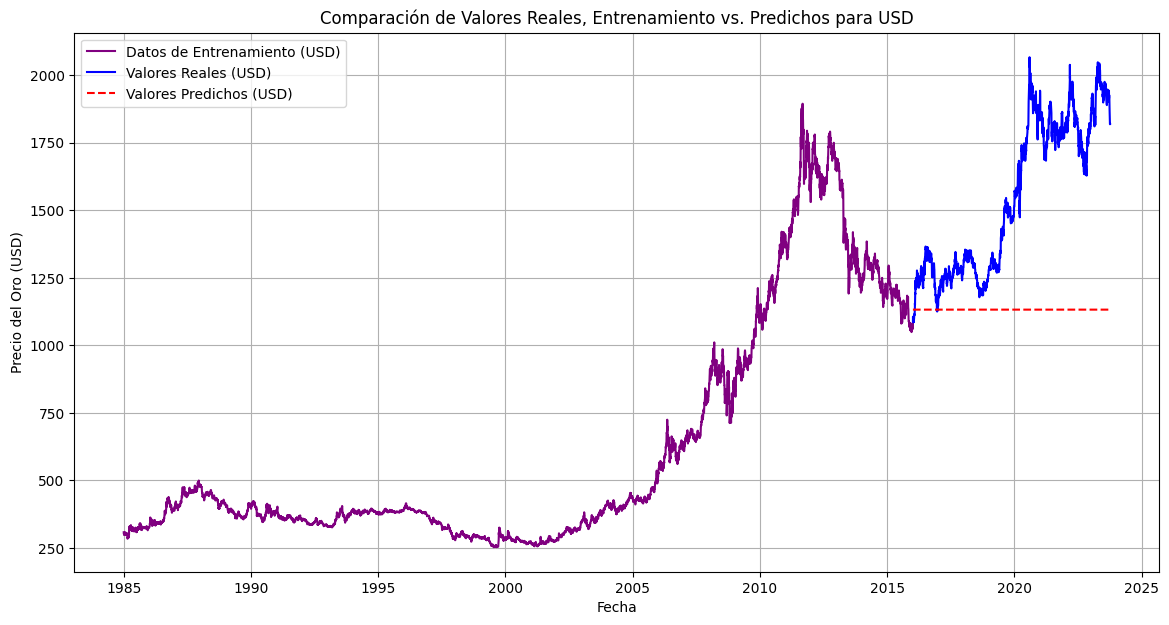

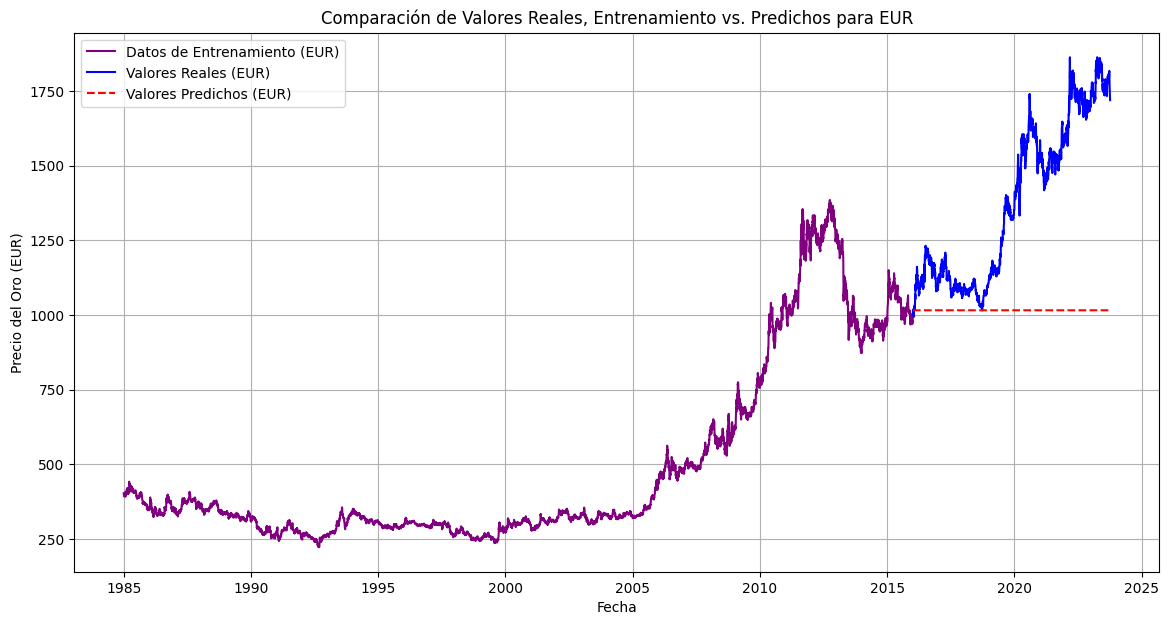

In [2]:
# Importar las librerías necesarias
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Establecer 'Date' como índice para el análisis de ES
daily_gold_rate_es = daily_gold_rate_benchmark.copy()
daily_gold_rate_es.set_index('Date', inplace=True)

# Establecer la frecuencia del índice como diaria
daily_gold_rate_es.index = pd.to_datetime(daily_gold_rate_es.index)
daily_gold_rate_es = daily_gold_rate_es.asfreq('B')  # Días hábiles

# División del conjunto de datos en entrenamiento y prueba
train_size_es = int(len(daily_gold_rate_es) * 0.8)
train_data_es = daily_gold_rate_es[:train_size_es]
test_data_es = daily_gold_rate_es[train_size_es:]

# Definir los valores posibles de los parámetros de suavizado
alpha_values = np.linspace(0.01, 1.0, 10)  # Valores posibles para alpha

# Función para optimizar el valor de alpha para una serie temporal dada
def optimizar_alpha(currency_data, test_data):
    best_rmse = float('inf')
    best_alpha = None
    best_model = None
    best_mae = None
    best_mape = None

    for alpha in alpha_values:
        try:
            model = ExponentialSmoothing(currency_data, trend=None, seasonal=None).fit(smoothing_level=alpha)
            predictions = model.forecast(len(test_data))
            
            # Calcular métricas de error
            rmse = np.sqrt(mean_squared_error(test_data, predictions))
            mae = mean_absolute_error(test_data, predictions)
            mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
                best_model = model
                best_mae = mae
                best_mape = mape
        except Exception as e:
            print(f"Error en alpha={alpha}: {e}")
            continue

    return best_alpha, best_rmse, best_mae, best_mape, best_model

# Optimización de alpha para USD y EUR
best_alpha_usd, best_rmse_usd, best_mae_usd, best_mape_usd, best_model_usd = optimizar_alpha(train_data_es['USD'], test_data_es['USD'])
best_alpha_eur, best_rmse_eur, best_mae_eur, best_mape_eur, best_model_eur = optimizar_alpha(train_data_es['EUR'], test_data_es['EUR'])

# Imprimir resultados para USD
print(f"Mejores parámetros para el modelo ES (USD): Alpha: {best_alpha_usd}")
print(f"RMSE: {best_rmse_usd}")
print(f"MAE: {best_mae_usd}")
print(f"MAPE: {best_mape_usd}%")

# Imprimir resultados para EUR
print(f"\nMejores parámetros para el modelo ES (EUR): Alpha: {best_alpha_eur}")
print(f"RMSE: {best_rmse_eur}")
print(f"MAE: {best_mae_eur}")
print(f"MAPE: {best_mape_eur}%")

# Graficar Comparativa de Valores Reales, Entrenamiento vs. Predichos (USD)
predictions_usd = best_model_usd.forecast(len(test_data_es))
plt.figure(figsize=(14, 7))
# Graficar los datos de entrenamiento
plt.plot(daily_gold_rate_es.index[:len(train_data_es)], train_data_es['USD'], label='Datos de Entrenamiento (USD)', color='purple')
# Graficar los valores reales (datos de prueba)
plt.plot(test_data_es.index, test_data_es['USD'], label='Valores Reales (USD)', color='blue')
# Graficar los valores predichos
plt.plot(test_data_es.index, predictions_usd, label='Valores Predichos (USD)', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (USD)')
plt.title('Comparación de Valores Reales, Entrenamiento vs. Predichos para USD')
plt.legend()
plt.grid()
plt.show()

# Graficar Comparativa de Valores Reales, Entrenamiento vs. Predichos (EUR)
predictions_eur = best_model_eur.forecast(len(test_data_es))
plt.figure(figsize=(14, 7))
# Graficar los datos de entrenamiento
plt.plot(daily_gold_rate_es.index[:len(train_data_es)], train_data_es['EUR'], label='Datos de Entrenamiento (EUR)', color='purple')
# Graficar los valores reales (datos de prueba)
plt.plot(test_data_es.index, test_data_es['EUR'], label='Valores Reales (EUR)', color='blue')
# Graficar los valores predichos
plt.plot(test_data_es.index, predictions_eur, label='Valores Predichos (EUR)', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (EUR)')
plt.title('Comparación de Valores Reales, Entrenamiento vs. Predichos para EUR')
plt.legend()
plt.grid()
plt.show()


## Interpretación de los Resultados del Modelo de Suavizado Exponencial (ES)

Después de optimizar los parámetros del modelo de **Suavizado Exponencial (ES)** aplicados a los precios del oro en **USD** y **EUR**, se obtuvieron los siguientes resultados:

### Resultados del Modelo
- **USD**:
  - **Alpha**: 0.01
  - **RMSE**: 501.45
  - **MAE**: 415.98
  - **MAPE**: 24.42%

- **EUR**:
  - **Alpha**: 0.01
  - **RMSE**: 450.88
  - **MAE**: 363.49
  - **MAPE**: 23.56%

### Interpretación de los Resultados
- Los resultados numéricos muestran un error considerablemente alto, tanto en **USD** como en **EUR**, con valores de **RMSE** y **MAE** que reflejan grandes diferencias entre los valores predichos y los valores reales. 
- En particular, los valores de **MAPE** en ambos casos son superiores al 20%, lo que indica que el modelo tiene una capacidad limitada para predecir con precisión los precios del oro.
- Las gráficas comparativas muestran que el modelo predice una **línea plana** para los valores futuros, lo es representativo del bajo valor de **Alpha** (0.01). Esto significa que el modelo está basando sus predicciones en promedios históricos y no está capturando los cambios recientes en las tendencias del precio del oro. 
- Esta predicción plana sugiere que el modelo **no es adecuado** para capturar las fluctuaciones o la volatilidad de los precios del oro en ambos mercados (USD y EUR), lo que refuerza la necesidad de explorar otros enfoques más sofisticados, como **Holt-Winters** o **ARIMA**, que puedan capturar la estructura de los datos con mayor detalle.

## Mejora del Modelo de Suavizado Exponencial (ES) Usando Ventanas Deslizantes

Con el objetivo de mejorar la precisión del modelo de **Suavizado Exponencial (ES)** aplicado a los precios del oro en **USD** y **EUR** a un nivel mas aceptable, se implementó un enfoque de **ventanas deslizantes**. Este método tiene como objetivo adaptar mejor el modelo a los valores más recientes y evaluar su rendimiento de manera continua a lo largo de un conjunto de validacion, esto debido a que como se menciono antes el modelo está basando sus predicciones en promedios históricos y no está capturando los cambios recientes en las tendencias del precio del oro

### Proceso

1. **División de los datos**: 
   - El conjunto de datos se dividió en tres partes:
     - **Entrenamiento** (70% de los datos)
     - **Validación** (15% de los datos)
     - **Prueba** (15% de los datos)
   
2. **Ventanas deslizantes**:
   - El modelo se entrena inicialmente con el conjunto de entrenamiento, ajustando sus parámetros con los datos de validación. Posteriormente, se desplaza la ventana hacia adelante, añadiendo nuevos datos a la base de entrenamiento y ajustando los parámetros del modelo en cada paso.
   - Este enfoque permite que el modelo se ajuste continuamente con datos de prediccion y del conjunto de validacion , lo que ayuda a capturar mejor las fluctuaciones en la serie temporal.
   
3. **Optimización de parámetros**:
   - Se realizó una búsqueda de valores óptimos del parámetro **Alpha** dentro de un rango predefinido utilizando el conjunto de validación.
   - Tras ajustar los parámetros, el modelo se probó contra el conjunto de prueba para evaluar su capacidad predictiva final.

4. **Evaluación del modelo**:
   - Se calcularon las métricas de error **RMSE**, **MAE**, y **MAPE** tanto en el conjunto de validación como en el conjunto de prueba para medir el desempeño del modelo ajustado y revisar si existe sobreajuste.


### Modelo de Suavizado Exponencial (ES) Usando Ventanas Deslizantes



Generando Predicciones: 100%|██████████| 1518/1518 [03:00<00:00,  8.43it/s]



--------------------------------------------------

Mejores parámetros para el modelo ES (USD): Alpha: 0.01
RMSE en Validación: 358.21612462706935
MAE en Validación: 324.2432766436425
MAPE en Validación: 26.217322069517714%
RMSE en Prueba: 256.41940160960286
MAE en Prueba: 230.963874256096
MAPE en Prueba: 14.954508027812356%


--------------------------------------------------

Mejores parámetros para el modelo ES (EUR): Alpha: 0.01
RMSE en Validación: 167.93183265705997
MAE en Validación: 144.8982944999768
MAPE en Validación: 14.116607823952092%
RMSE en Prueba: 358.23351333606917
MAE en Prueba: 311.5950077468152
MAPE en Prueba: 19.90202057355063%



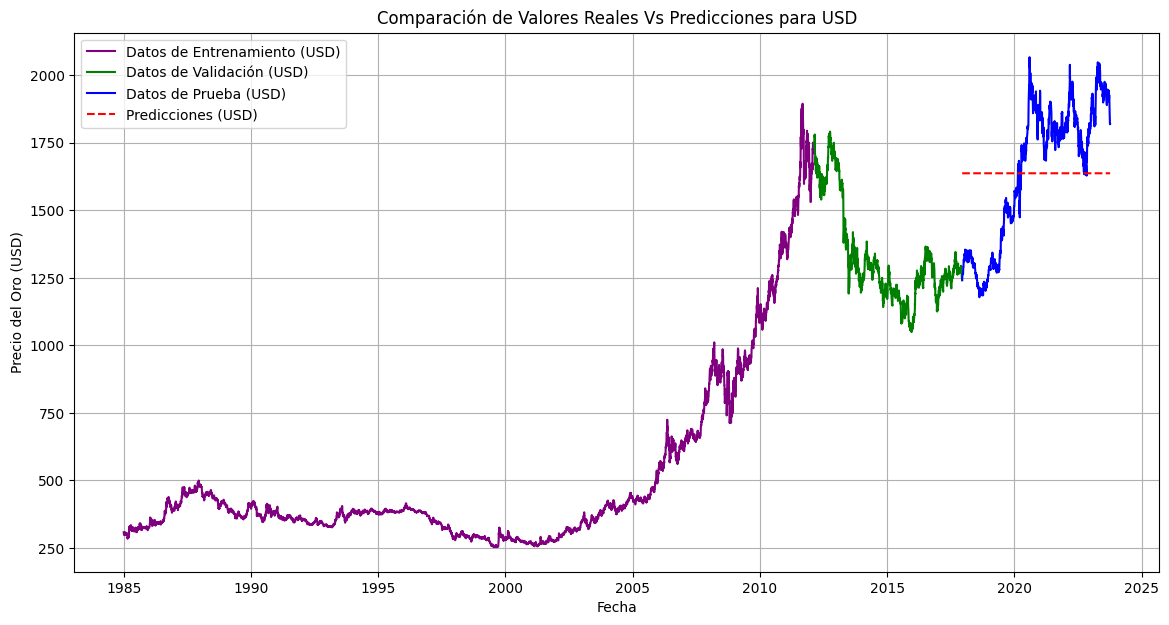

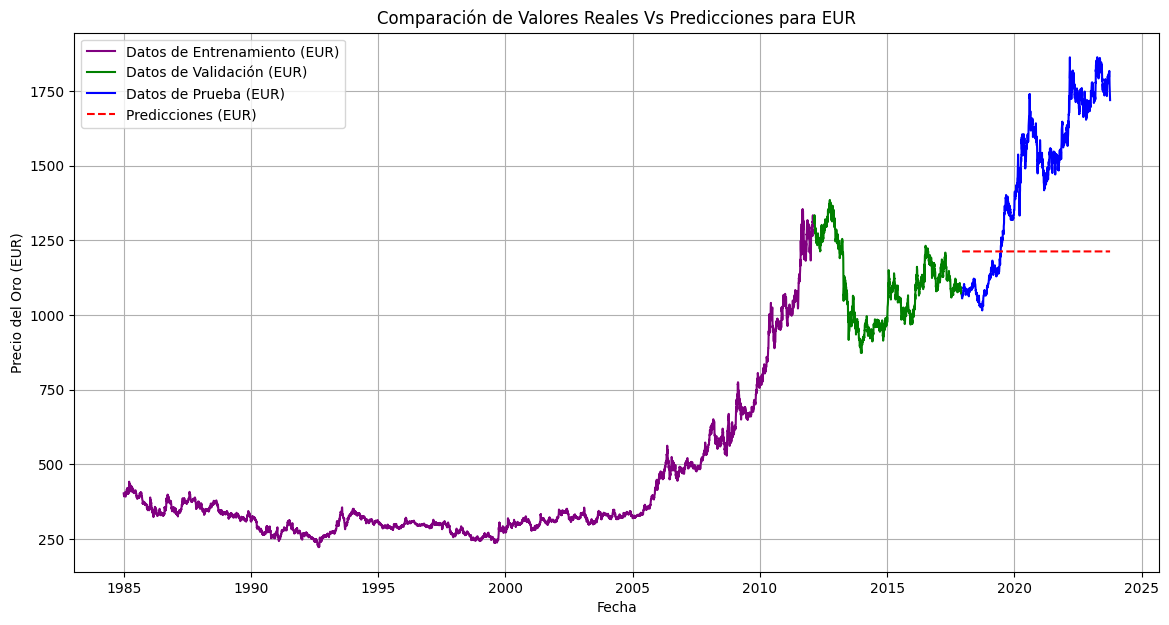

In [3]:
# Importar las librerías necesarias
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import warnings

# Desactiva los warnings del sistema
os.environ["PYTHONWARNINGS"] = "ignore"
warnings.filterwarnings("ignore")

# Establecer 'Date' como índice para el análisis de ES
daily_gold_rate_es = daily_gold_rate_benchmark.copy()
daily_gold_rate_es.set_index('Date', inplace=True)

# Establecer la frecuencia del índice como diaria 
daily_gold_rate_es.index = pd.to_datetime(daily_gold_rate_es.index)
daily_gold_rate_es = daily_gold_rate_es.asfreq('B')  # Días hábiles

# División del conjunto de datos en entrenamiento (70%), validación (15%) y prueba (15%)
train_size_es = int(len(daily_gold_rate_es) * 0.7)
val_size_es = int(len(daily_gold_rate_es) * 0.15)
test_size_es = len(daily_gold_rate_es) - train_size_es - val_size_es

train_data_es = daily_gold_rate_es[:train_size_es]
val_data_es = daily_gold_rate_es[train_size_es:train_size_es + val_size_es]
test_data_es = daily_gold_rate_es[train_size_es + val_size_es:]

# Definir los valores posibles de los parámetros de suavizado
alpha_values = np.linspace(0.01, 1.0, 10)  # Valores posibles para alpha

# Función para ajustar el modelo y calcular el RMSE en validación
def ajustar_modelo(currency, alpha):
    try:
        model = ExponentialSmoothing(train_data_es[currency], trend=None, seasonal=None).fit(smoothing_level=alpha)
        val_predictions = []
        history = list(train_data_es[currency])  

        for t in range(len(val_data_es)):
            prediction = model.forecast(1)[0]
            val_predictions.append(prediction)
            history.append(val_data_es[currency].iloc[t])  

        # Calcular RMSE en el conjunto de validación
        rmse = np.sqrt(mean_squared_error(val_data_es[currency], val_predictions))
        mae = mean_absolute_error(val_data_es[currency], val_predictions)
        mape = np.mean(np.abs((val_data_es[currency] - val_predictions) / val_data_es[currency])) * 100
        return (alpha, rmse, mae, mape, model)
    except Exception as e:
        print(f"Error en alpha={alpha}: {e}")
        return (alpha, float('inf'), float('inf'), float('inf'), None)

# Ejecucion en paralelo usando 10 núcleos
resultados_usd = Parallel(n_jobs=10)(delayed(ajustar_modelo)('USD', alpha) for alpha in tqdm(alpha_values, desc="Optimizando USD"))
resultados_eur = Parallel(n_jobs=10)(delayed(ajustar_modelo)('EUR', alpha) for alpha in tqdm(alpha_values, desc="Optimizando EUR"))

# Encontrar el mejor modelo basado en RMSE para USD
best_result_usd = min(resultados_usd, key=lambda x: x[1])
best_alpha_usd, best_rmse_usd, best_mae_usd, best_mape_usd, best_model_usd = best_result_usd

# Encontrar el mejor modelo basado en RMSE para EUR
best_result_eur = min(resultados_eur, key=lambda x: x[1])
best_alpha_eur, best_rmse_eur, best_mae_eur, best_mape_eur, best_model_eur = best_result_eur

# Usar el mejor modelo encontrado para predecir sobre el conjunto de prueba
def generar_predicciones(model, history, test_data):
    test_predictions = []
    for t in tqdm(range(len(test_data)), desc="Generando Predicciones"):
        prediction = model.forecast(1)[0]
        test_predictions.append(prediction)
        history.append(prediction)  
    return test_predictions

test_predictions_usd = generar_predicciones(best_model_usd, list(train_data_es['USD']) + list(val_data_es['USD']), test_data_es['USD'])
test_predictions_eur = generar_predicciones(best_model_eur, list(train_data_es['EUR']) + list(val_data_es['EUR']), test_data_es['EUR'])

print("\n" + "-"*50 + "\n")

# Evaluar el rendimiento en el conjunto de prueba para USD
rmse_test_usd = np.sqrt(mean_squared_error(test_data_es['USD'], test_predictions_usd))
mae_test_usd = mean_absolute_error(test_data_es['USD'], test_predictions_usd)
mape_test_usd = np.mean(np.abs((test_data_es['USD'] - test_predictions_usd) / test_data_es['USD'])) * 100

# Evaluar el rendimiento en el conjunto de prueba para EUR
rmse_test_eur = np.sqrt(mean_squared_error(test_data_es['EUR'], test_predictions_eur))
mae_test_eur = mean_absolute_error(test_data_es['EUR'], test_predictions_eur)
mape_test_eur = np.mean(np.abs((test_data_es['EUR'] - test_predictions_eur) / test_data_es['EUR'])) * 100

# Imprimir resultados para USD
print(f"Mejores parámetros para el modelo ES (USD): Alpha: {best_alpha_usd}")
print(f"RMSE en Validación: {best_rmse_usd}")
print(f"MAE en Validación: {best_mae_usd}")
print(f"MAPE en Validación: {best_mape_usd}%")
print(f"RMSE en Prueba: {rmse_test_usd}")
print(f"MAE en Prueba: {mae_test_usd}")
print(f"MAPE en Prueba: {mape_test_usd}%\n")

print("\n" + "-"*50 + "\n")

# Imprimir resultados para EUR
print(f"Mejores parámetros para el modelo ES (EUR): Alpha: {best_alpha_eur}")
print(f"RMSE en Validación: {best_rmse_eur}")
print(f"MAE en Validación: {best_mae_eur}")
print(f"MAPE en Validación: {best_mape_eur}%")
print(f"RMSE en Prueba: {rmse_test_eur}")
print(f"MAE en Prueba: {mae_test_eur}")
print(f"MAPE en Prueba: {mape_test_eur}%\n")

# Graficar los resultados con colores diferenciados para USD
plt.figure(figsize=(14, 7))
plt.plot(train_data_es.index, train_data_es['USD'], label='Datos de Entrenamiento (USD)', color='purple')
plt.plot(val_data_es.index, val_data_es['USD'], label='Datos de Validación (USD)', color='green')
plt.plot(test_data_es.index, test_data_es['USD'], label='Datos de Prueba (USD)', color='blue')
plt.plot(test_data_es.index, test_predictions_usd, label='Predicciones (USD)', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (USD)')
plt.title('Comparación de Valores Reales Vs Predicciones para USD')
plt.legend()
plt.grid()
plt.show()
daily_gold_rate_benchmark = pd.read_csv('daily_gold_rate.csv', parse_dates=['Date'])
daily_gold_rate_benchmark = daily_gold_rate_benchmark[['Date', 'USD', 'EUR']].dropna()
# Graficar los resultados con colores diferenciados para EUR
plt.figure(figsize=(14, 7))
plt.plot(train_data_es.index, train_data_es['EUR'], label='Datos de Entrenamiento (EUR)', color='purple')
plt.plot(val_data_es.index, val_data_es['EUR'], label='Datos de Validación (EUR)', color='green')
plt.plot(test_data_es.index, test_data_es['EUR'], label='Datos de Prueba (EUR)', color='blue')
plt.plot(test_data_es.index, test_predictions_eur, label='Predicciones (EUR)', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (EUR)')
plt.title('Comparación de Valores Reales Vs Predicciones para EUR')
plt.legend()
plt.grid()
plt.show()


### Interpretación de los Resultados del Modelo de Suavizado Exponencial (ES) Usando Ventanas Deslizantes

Después de aplicar el enfoque de **ventanas deslizantes** al modelo de **Suavizado Exponencial (ES)** para intentar mejorar su precisión al predecir los precios del oro en **USD** y **EUR**, se obtuvieron los siguientes resultados:

### Resultados del Modelo (Ventanas Deslizantes)

- **USD**:
  - **Alpha**: 0.01
  - **RMSE en Validación**: 358.22
  - **MAE en Validación**: 324.24
  - **MAPE en Validación**: 26.22%
  - **RMSE en Prueba**: 256.42
  - **MAE en Prueba**: 230.96
  - **MAPE en Prueba**: 14.95%

- **EUR**:
  - **Alpha**: 0.01
  - **RMSE en Validación**: 167.93
  - **MAE en Validación**: 144.90
  - **MAPE en Validación**: 14.12%
  - **RMSE en Prueba**: 358.23
  - **MAE en Prueba**: 311.60
  - **MAPE en Prueba**: 19.90%

### Interpretación de los Resultados

- **USD**:
  - El **RMSE** y **MAE** en el conjunto de validación son considerablemente más altos que en el conjunto de prueba, lo que sugiere que el modelo pudo haber ajustado mejor los datos recientes. El valor de **MAPE** en el conjunto de prueba, aunque menor que en validación, sigue siendo alto (14.95%), lo que indica que el modelo aún no captura con precisión las fluctuaciones recientes del mercado.

- **EUR**:
  - En los resultados de **EUR** se observa un **MAPE** más alto en prueba que en validación, lo que sugiere que el modelo no generaliza adecuadamente para datos no vistos durante el entrenamiento. Las predicciones también muestran una tendencia plana, lo que indica que el modelo no está capturando correctamente las tendencias del mercado.

### Comparación con el Modelo Anterior (Sin Ventanas Deslizantes)

- Para **USD**, el enfoque de ventanas deslizantes mejoró significativamente el **RMSE** y **MAE**, lo que indica que el modelo se ajusta mejor a las tendencias recientes. Sin embargo, el **MAPE** sigue siendo alto, mostrando que el modelo aún no es capaz de capturar las fluctuaciones del mercado.

- En **EUR**, aunque el **RMSE** y **MAE** son mejores con el enfoque de ventanas deslizantes, el **MAPE** sigue siendo elevado, lo que refleja que el modelo no logra capturar detalladamente las fluctuaciones de los precios en esta moneda.

### Indicios de Sobreajuste

- En el caso de **USD**, el **MAPE** en el conjunto de prueba (14.95%) es menor que en el conjunto de validación (26.22%), lo que sugiere que **no hay sobreajuste**, ya que el modelo se está desempeñando mejor con datos que no ha visto antes. Esto indica que el modelo ha generalizado bien a los datos de prueba.

- En el caso de **EUR**, el **MAPE** en el conjunto de prueba (19.90%) es mayor que en el conjunto de validación (14.12%), lo que podría indicar que el modelo está sufriendo **sobreajuste**, ya que no está generalizando tan bien a los datos de prueba y tiene un peor rendimiento en comparación con el conjunto de validación.

### Análisis de la Tendencia Gráfica

- Las gráficas muestran una **predicción plana**, lo que sugiere que el modelo no está capturando las tendencias recientes de los precios del oro. A pesar de la optimización de los parámetros, el modelo parece seguir dependiendo demasiado de los valores históricos.

### Conclusión General sobre el Modelo de Suavizado Exponencial (ES)

El modelo de **Suavizado Exponencial (ES)**, tanto en su versión básica como con el enfoque de **ventanas deslizantes**, presenta limitaciones para capturar las fluctuaciones y la volatilidad en los precios del oro, tanto en **USD** como en **EUR**. Si bien el enfoque de ventanas deslizantes ha mostrado mejoras en **RMSE** y **MAE**, el modelo sigue teniendo dificultades para adaptarse a las tendencias recientes, especialmente en el caso de **MAPE**, que sigue siendo alto en ambos enfoques.

#### Consideraciones Finales sobre el Modelo ES:

- El modelo **ES** es adecuado para series temporales con patrones estables y no demasiado volátiles, pero no parece ser adecuado para este caso, ya que estamos hablando de datos moderadamente volátiles y con mucho ruido.
- La falta de una tendencia clara en los datos de predicción sugiere que es necesario probar otros modelos que puedan capturar mejor las características de la serie temporal.

En resumen, el enfoque de **Suavizado Exponencial** ha mostrado algunos resultados positivos en la predicción de tendencias generales, pero no es el modelo más adecuado para capturar las fluctuaciones a corto plazo en los precios del oro.


### Implementacion del Modelo Holt-Winters

A continuación, se implementará el modelo de **Holt-Winters** para los precios del oro en **USD** y **EUR**, considerando los componentes de **tendencia**, pero no **estacionalidad**. Dado que los precios del oro no presentan un comportamiento estacional claro, el único patrón identificado se caracteriza por la subida de los precios durante crisis económicas entre los años estudiados. Esto se debe a que el precio del oro mostró un claro comportamiento de crecimiento en esos periodos. El modelo será evaluado en las mismas condiciones que el de suavización exponencial simple, además de evaluar la capacidad para capturar las fluctuaciones más realistas en el comportamiento en comparación con el modelo **ES**.

### Parámetros
- Se decidió usar `trend='mul'` dentro del modelo debido a la **tendencia positiva clara** encontrada en el Análisis Exploratorio de Datos.
- El modelo usará `seasonal=None`, dado que en el EDA la **descomposición STL** no mostró ningún comportamiento estacional claro.
- Para el modelo se optimizarán los valores de los parámetros **Alpha** y **Beta** utilizando la técnica de **Grid search**.

Mejores parámetros para el modelo H-W (USD): Alpha: 0.23, Beta: 0.12
RMSE: 131.86289910386884
MAE: 104.01542736896363
MAPE: 6.691415400748299%

Mejores parámetros para el modelo H-W (EUR): Alpha: 0.12, Beta: 0.12
RMSE: 106.39036767472794
MAE: 86.4415098401811
MAPE: 6.496584479747685%


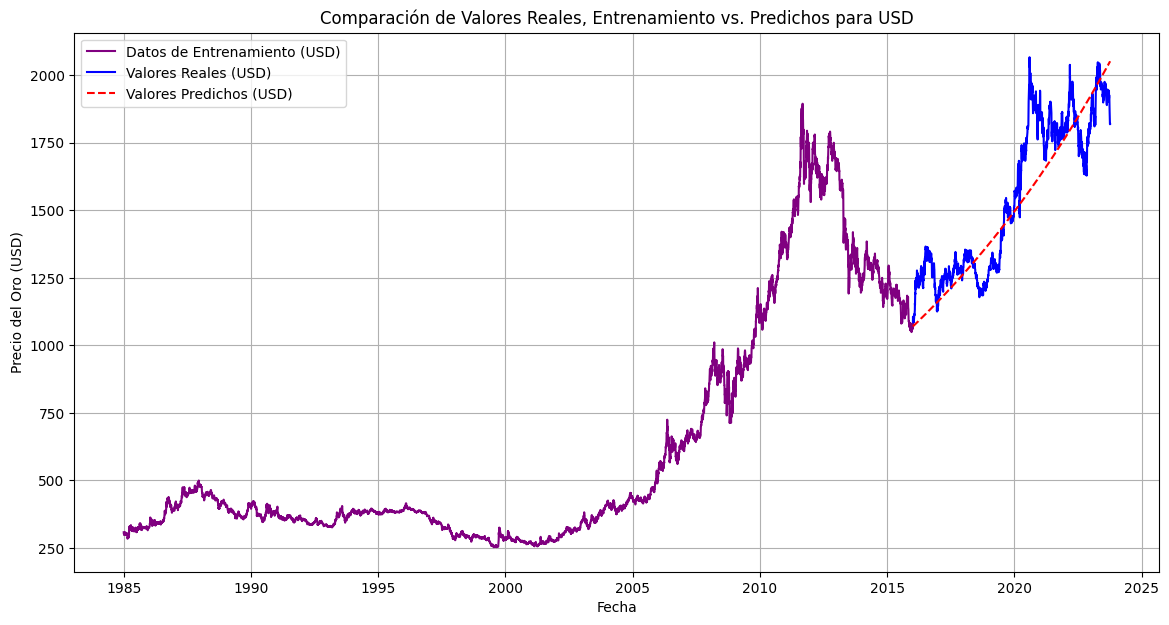

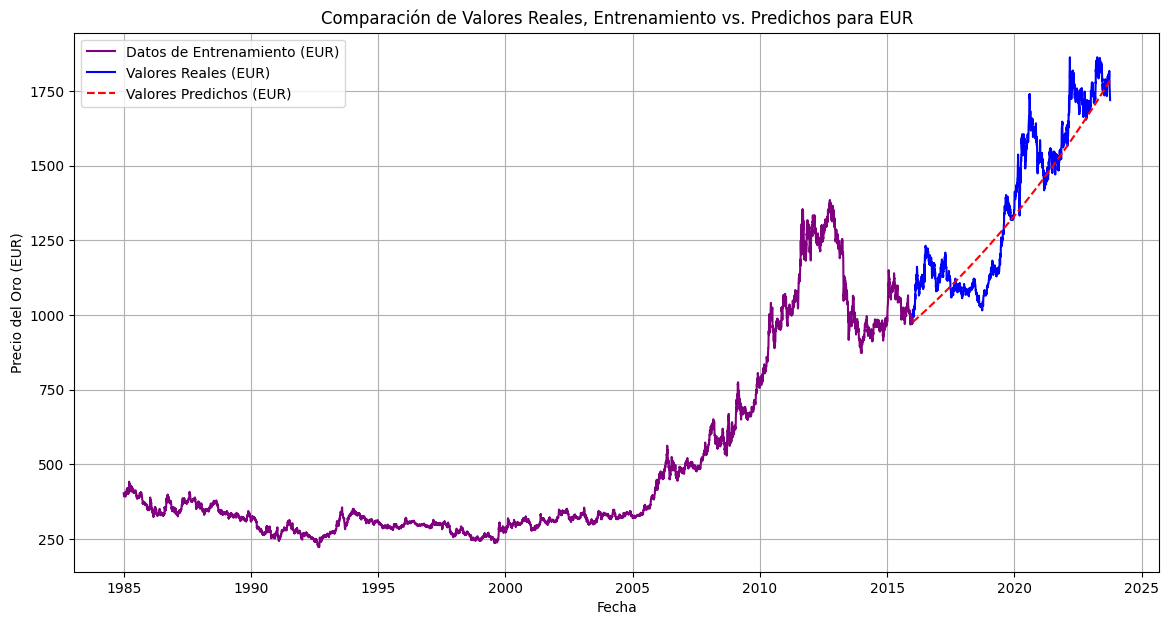

In [4]:

# Establecer 'Date' como índice para el análisis de HS
daily_gold_rate_hs = daily_gold_rate_benchmark.copy()
daily_gold_rate_hs.set_index('Date', inplace=True)

# Establecer la frecuencia del índice como diaria
daily_gold_rate_hs.index = pd.to_datetime(daily_gold_rate_hs.index)
daily_gold_rate_hs = daily_gold_rate_hs.asfreq('B')  # Días hábiles

# División del conjunto de datos en entrenamiento y prueba
train_size_hs = int(len(daily_gold_rate_hs) * 0.8)
train_data_hs = daily_gold_rate_hs[:train_size_hs]
test_data_hs = daily_gold_rate_hs[train_size_hs:]

# Definir los valores posibles de los parámetros de suavizado
alpha_values = np.linspace(0.01, 1.0, 10)  # Valores posibles para alpha
beta_values = np.linspace(0.01, 1.0, 10)   # Valores posibles para beta

# Función para optimizar alpha y beta para una serie temporal dada
def optimizar_parametros(currency_data, test_data):
    best_rmse = float('inf')
    best_alpha = None
    best_beta = None
    best_model = None
    best_mae = None
    best_mape = None

    for alpha in alpha_values:
        for beta in beta_values:
            try:
                # Modelo con tendencia multiplicativa
                model = ExponentialSmoothing(currency_data, trend='mul', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta)
                predictions = model.forecast(len(test_data))
                
                # Calcular métricas de error
                rmse = np.sqrt(mean_squared_error(test_data, predictions))
                mae = mean_absolute_error(test_data, predictions)
                mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_alpha = alpha
                    best_beta = beta
                    best_model = model
                    best_mae = mae
                    best_mape = mape
            except Exception as e:
                print(f"Error en alpha={alpha}, beta={beta}: {e}")
                continue

    return best_alpha, best_beta, best_rmse, best_mae, best_mape, best_model

# Optimización de alpha y beta para USD y EUR
best_alpha_usd, best_beta_usd, best_rmse_usd, best_mae_usd, best_mape_usd, best_model_usd = optimizar_parametros(train_data_hs['USD'], test_data_hs['USD'])
best_alpha_eur, best_beta_eur, best_rmse_eur, best_mae_eur, best_mape_eur, best_model_eur = optimizar_parametros(train_data_hs['EUR'], test_data_hs['EUR'])

# Imprimir resultados para USD
print(f"Mejores parámetros para el modelo H-W (USD): Alpha: {best_alpha_usd}, Beta: {best_beta_usd}")
print(f"RMSE: {best_rmse_usd}")
print(f"MAE: {best_mae_usd}")
print(f"MAPE: {best_mape_usd}%")

# Imprimir resultados para EUR
print(f"\nMejores parámetros para el modelo H-W (EUR): Alpha: {best_alpha_eur}, Beta: {best_beta_eur}")
print(f"RMSE: {best_rmse_eur}")
print(f"MAE: {best_mae_eur}")
print(f"MAPE: {best_mape_eur}%")

# Graficar Comparativa de Valores Reales, Entrenamiento vs. Predichos (USD)
predictions_usd = best_model_usd.forecast(len(test_data_hs))
plt.figure(figsize=(14, 7))
# Graficar los datos de entrenamiento
plt.plot(daily_gold_rate_hs.index[:len(train_data_hs)], train_data_hs['USD'], label='Datos de Entrenamiento (USD)', color='purple')
# Graficar los valores reales (datos de prueba)
plt.plot(test_data_hs.index, test_data_hs['USD'], label='Valores Reales (USD)', color='blue')
# Graficar los valores predichos
plt.plot(test_data_hs.index, predictions_usd, label='Valores Predichos (USD)', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (USD)')
plt.title('Comparación de Valores Reales, Entrenamiento vs. Predichos para USD')
plt.legend()
plt.grid()
plt.show()

# Graficar Comparativa de Valores Reales, Entrenamiento vs. Predichos (EUR)
predictions_eur = best_model_eur.forecast(len(test_data_hs))
plt.figure(figsize=(14, 7))
# Graficar los datos de entrenamiento
plt.plot(daily_gold_rate_hs.index[:len(train_data_hs)], train_data_hs['EUR'], label='Datos de Entrenamiento (EUR)', color='purple')
# Graficar los valores reales (datos de prueba)
plt.plot(test_data_hs.index, test_data_hs['EUR'], label='Valores Reales (EUR)', color='blue')
# Graficar los valores predichos
plt.plot(test_data_hs.index, predictions_eur, label='Valores Predichos (EUR)', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (EUR)')
plt.title('Comparación de Valores Reales, Entrenamiento vs. Predichos para EUR')
plt.legend()
plt.grid()
plt.show()

## Interpretación de los Resultados del Modelo Holt-Winters (HS) para USD y EUR

El **modelo de Holt-Winters** después de ser optimizado para la predicción de los precios del oro en **USD** y **EUR** utilizando **Grid search** obtuvo los siguientes resultados:

### Resultados del Modelo Holt-Winters para USD y EUR

- **USD**:
  - **Alpha**: 0.23
  - **Beta**: 0.12
  - **RMSE**: 131.86
  - **MAE**: 104.02
  - **MAPE**: 6.69%

- **EUR**:
  - **Alpha**: 0.12
  - **Beta**: 0.12
  - **RMSE**: 106.39
  - **MAE**: 86.44
  - **MAPE**: 6.50%

### Interpretación de los Resultados para USD y EUR

- **Alpha y Beta**: 
  - En **USD**, el valor de **Alpha** es ligeramente mayor (0.23) que en **EUR** (0.12), lo que indica que el modelo para **USD** otorga más peso a las observaciones recientes, permitiendo una mayor respuesta a los cambios recientes en la tendencia. En **EUR**, el menor valor de **Alpha** sugiere que el modelo es más conservador, reflejando una menor influencia de las observaciones recientes.
  - Ambos modelos comparten un valor bajo de **Beta** (0.12), lo que refleja que los cambios en la tendencia no son abruptos, capturando una **tendencia más suave** y estable en el tiempo para ambas divisas.

- **RMSE y MAE**: 
  - El modelo tiene un **mejor rendimiento en EUR**, con **RMSE** y **MAE** menores en comparación con **USD**. Esto sugiere una mejor adaptación a las tendencias de los precios del oro en **EUR** y puede indicar una menor volatilidad en esta divisa.

- **MAPE**: 
  - Los valores de **MAPE** son bajos en ambos casos (6.69% para **USD** y 6.50% para **EUR**), lo que indica que el modelo tiene un buen rendimiento general en ambas divisas, con errores relativos aceptables que permiten capturar la **tendencia general** del mercado con precisión.

### Captura de la Tendencia

- **Captura de la Tendencia General**: El modelo **Holt-Winters** ha capturado la **tendencia positiva general** de los precios del oro tanto en **USD** como en **EUR** de manera efectiva. La **línea de predicción** sigue de cerca la trayectoria de crecimiento observada en ambas divisas.
- **Comparación con el Modelo ES**: A diferencia del modelo **Suavizado Exponencial (ES)**, que predecía una línea plana, el modelo **Holt-Winters** sigue con mayor precisión la tendencia creciente. Esto es evidente en ambas divisas, donde la **línea de predicción** refleja mejor los incrementos a largo plazo.
- **Limitaciones en la Volatilidad**: Aunque el modelo captura correctamente la **tendencia general** en ambas divisas, sigue teniendo dificultades para reflejar las **fluctuaciones de corto plazo** y la **volatilidad** del mercado. Las fluctuaciones no son representadas con exactitud, lo que indica que el modelo suaviza demasiado los movimientos del mercado.

### Conclusiónes Generales sobre el Modelo Holt-Winters (H-W)

- **Mejora significativa respecto al Modelo ES**: El modelo **Holt-Winters** ha demostrado una mejora notable en la captura de la **tendencia general** del mercado en ambas divisas, con **menores errores** y un ajuste más preciso que el modelo **ES**.
- **Mejor ajuste en EUR**: Aunque el modelo funciona bien en ambas divisas, los **errores** en **EUR** son menores, lo que muestra las diferencias en la volatilidad del mercado entre **USD** y **EUR**.
- **Volatilidad**: A pesar de la mejora en la captura de la tendencia, el modelo **no refleja las fluctuaciones a corto plazo**, lo que podría requerir ajustes adicionales o el uso de modelos que sean más sensibles a la **volatilidad** y los cambios abruptos.

El modelo **Holt-Winters** ha mejorado significativamente el rendimiento predictivo en comparacion al modelo **ES**, capturando correctamente la tendencia general en ambos mercados. Sin embargo, aún se presentan desafíos en la predicción de la volatilidad de corto plazo.

## Evaluación de Potenciales Periodos Estacionales para el Modelo Holt-Winters

Aunque el análisis exploratorio de datos (EDA) no mostró evidencia clara de estacionalidad en los precios del oro, se decidió probar varios **periodos estacionales** como parte de un **análisis** exhaustivo con el objetivo de verificar si existía algún **patrón estacional** que **no** hubiera sido identificado previamente.

Con el objetivo de confirmar la existencia de algún **patrón estacional**, se tomaron los siguientes pasos:

- Se seleccionaron **periodos estacionales** posibles, abarcando desde una semana a 8 años, para explorar posibles ciclos no identificados en el análisis inicial.
- Se utilizo tanto **tendencia aditiva** como **tendencia multiplicativa** en cada combinación de parámetros.
- Los modelos de Holt-Winters tuvieron sus componentes optimizados y se calcularon las métricas de error para evaluar el rendimiento de cada configuración.


In [5]:
# Importar las librerías necesarias
from joblib import Parallel, delayed, parallel_backend
import logging

logging.captureWarnings(True)

# Establecer 'Date' como índice para el análisis de ES
daily_gold_rate_test = daily_gold_rate_benchmark.copy()
daily_gold_rate_test.set_index('Date', inplace=True)

# Establecer la frecuencia del índice como diaria
daily_gold_rate_test.index = pd.to_datetime(daily_gold_rate_test.index)
daily_gold_rate_test = daily_gold_rate_test.asfreq('B')  # Días hábiles

# División del conjunto de datos en entrenamiento (80%) y prueba (20%)
train_size_test = int(len(daily_gold_rate_test) * 0.8)
train_data_test = daily_gold_rate_test[:train_size_test]
test_data_test = daily_gold_rate_test[train_size_test:]

# Definir los valores posibles de seasonal_periods, añadiendo más opciones intermedias
seasonal_periods_values = [7, 15, 31, 45, 60, 90, 120, 150, 182, 200, 250, 270, 365, 500, 700, 800, 1000, 1500, 2080, 3000]
trend_options = ['add', 'mul']  
seasonal_option = 'add' 
# Función para ajustar el modelo y calcular las métricas de error
def optimizar_holt_winters(trend_option, period):
    try:
        # Ajuste del modelo Holt-Winters
        model = ExponentialSmoothing(train_data_test['USD'], trend=trend_option, seasonal=seasonal_option, seasonal_periods=period).fit()
        predictions = model.forecast(len(test_data_test))

        # Obtener los valores de alpha, beta, gamma
        alpha = model.params['smoothing_level']
        beta = model.params['smoothing_trend']
        gamma = model.params['smoothing_seasonal']

        # Calcular métricas de error
        rmse = np.sqrt(mean_squared_error(test_data_test['USD'], predictions))
        mae = mean_absolute_error(test_data_test['USD'], predictions)
        mape = np.mean(np.abs((test_data_test['USD'] - predictions) / test_data_test['USD'])) * 100

        return {
            'trend': trend_option,
            'seasonal_period': period,
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        }
    except Exception as e:
        return None

# Paralelización usando joblib con parallel_backend
with parallel_backend('threading', n_jobs=14):
    results = Parallel()(delayed(optimizar_holt_winters)(trend_option, period) 
                         for trend_option in trend_options 
                         for period in seasonal_periods_values)

# Filtrar los resultados válidos
results = [result for result in results if result is not None]

# Imprimir todos los resultados
print("Resultados para diferentes combinaciones de parámetros seasonal_option = 'add':")
for result in results:
    print(f"Trend: {result['trend']}, Periodo estacional: {result['seasonal_period']}, Alpha: {result['alpha']}, Beta: {result['beta']}, Gamma: {result['gamma']} - RMSE: {result['rmse']}, MAE: {result['mae']}, MAPE: {result['mape']}%")

# Encontrar y mostrar el mejor resultado
mejor_resultado = min(results, key=lambda x: x['rmse'])
print(f"\nMejor combinación de parámetros: {mejor_resultado}")


Resultados para diferentes combinaciones de parámetros seasonal_option = 'add':
Trend: add, Periodo estacional: 7, Alpha: 0.9935119979188447, Beta: 0.0017604623399647917, Gamma: 0.00646891201284708 - RMSE: 930.403632524506, MAE: 806.8108325692517, MAPE: 48.394289654869276%
Trend: add, Periodo estacional: 15, Alpha: 0.9565429751698167, Beta: 0.004992755046610034, Gamma: 0.008777389669000291 - RMSE: 1165.1681127657987, MAE: 1011.6618711613305, MAPE: 60.78763694064481%
Trend: add, Periodo estacional: 31, Alpha: 0.9948562380175525, Beta: 0.0035999963999705413, Gamma: 0.00510163275809889 - RMSE: 1148.789512983282, MAE: 998.0430794341268, MAPE: 59.98066345217268%
Trend: add, Periodo estacional: 45, Alpha: 0.9585934000949805, Beta: 0.00026252213826226595, Gamma: 0.01641740715972476 - RMSE: 447.35267812866243, MAE: 381.5147312386008, MAPE: 22.693383280959438%
Trend: add, Periodo estacional: 60, Alpha: 0.9508953772178569, Beta: 0.007134287883030872, Gamma: 0.009841477737554716 - RMSE: 1171.6406

### Resultados de los Periodos Estacionales para el Modelo Holt-Winters

Después del proceso de optimización, los **periodos estacionales** con mejor desempeño fueron **800, 150, 3000, 200 y 182 días**. Estos resultados, sin embargo, no muestran una mejora significativa en comparación con el modelo sin componente, ya que todos presentaron precisiones ligeramente menores que este (MAPE de 6.69% para USD y 6.50% para EUR).

- **Periodo estacional: 800 días** - MAPE: 6.71%
- **Periodo estacional: 150 días** - MAPE: 6.76%
- **Periodo estacional: 3000 días** - MAPE: 7.97%
- **Periodo estacional: 200 días** - MAPE: 7.48%
- **Periodo estacional: 182 días** - MAPE: 9.16%

#### Precisión de las Predicciones:

- **MAPE, RMSE y MAE**: Los valores de **MAPE** para los cinco mejores periodo estacianales se encuentran entre 6.71% y 9.16%, lo que indica que la inclusión de estacionalidad no ha mejorado sustancialmente el ajuste respecto al modelo sin estacionalidad (MAPE de 6.69% y 6.50% para USD y EUR). En términos de **RMSE** y **MAE**, los resultados con estacionalidad son en general similares o levemente inferiores al modelo sin estacionalidad, lo que sugiere que el componente estacional no aporta beneficios significativos en la capacidad predictiva.

#### Análisis de Alpha, Beta y Gamma:
- **Alpha**: En todos los resultados, **Alpha** se mantiene muy alto (cercano a 1.0), a diferencia del modelo sin estacionalidad, lo que indica priorización de las observaciones recientes.
- **Beta y Gamma**: Los valores de **Beta** y **Gamma** son extremadamente bajos (~0.0001 en todas las combinaciones), en contraste con los valores del modelo sin estacionalidad (Beta: 0.12). Esto sugiere que la inclusión de la estacionalidad tiene un impacto leve en la precisión de este modelo además, los bajos valores de **Gamma** refuerzan que el componente estacional tiene un efecto mínimo en la misma, reforzando la no estacionalidad observada en el **EDA**.

### Conclusión del Componente Estacional:
Los valores de **Alpha**, **Beta** y **Gamma** indican que el modelo depende de las observaciones recientes y mantiene una tendencia estable, mientras que la estacionalidad tiene un impacto limitado. La inclusión de estacionalidad no ha aportado mejoras significativas en el ajuste ni en la precisión, lo cual concuerda con el EDA, que mostró una estacionalidad débil en los datos de precios del oro.

### Visualización y Comparación Gráfica de Modelos Estacionales y Benchmark

Se realizara una **comparación gráfica** entre los dos modelos estacionales con mejor desempeño y un modelo benchmark sin componente estacional. Esta comparación permitira evaluar visualmente las diferencias en la precisión de las predicciones y revisar el ajuste de los modelos de la tendencia de los precios del oro.


Resultados Top 1:
  RMSE: 131.36536570669602
  MAE: 103.21390342267966
  MAPE: 6.712426442867043%



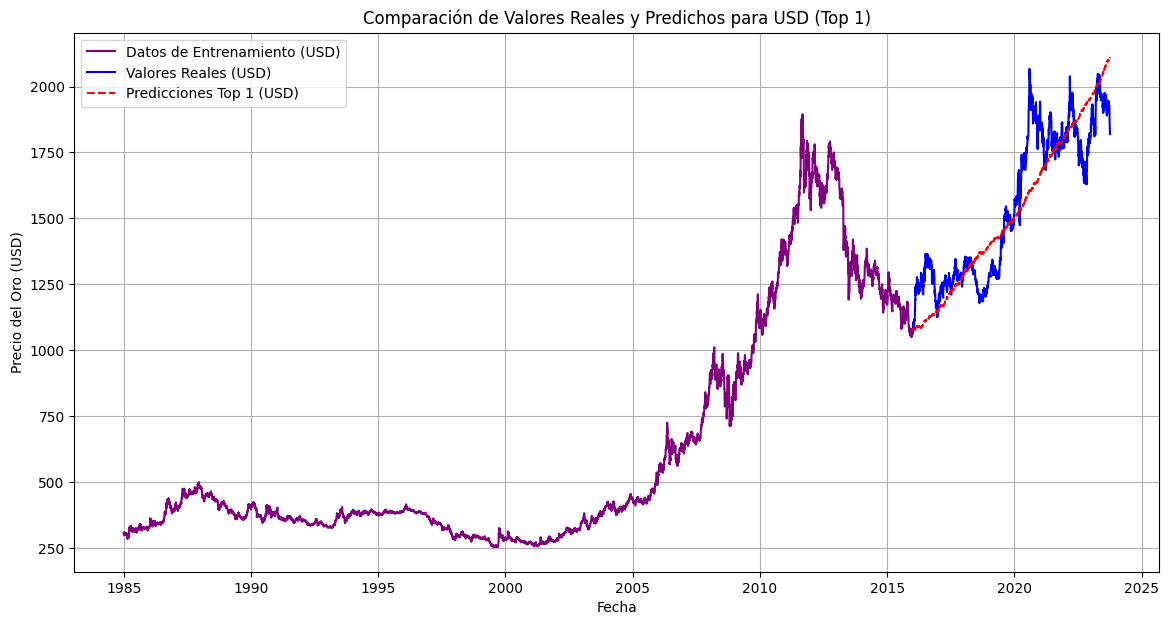

Resultados Top 2:
  RMSE: 134.1766117705416
  MAE: 105.74034938882657
  MAPE: 6.7575016034537985%



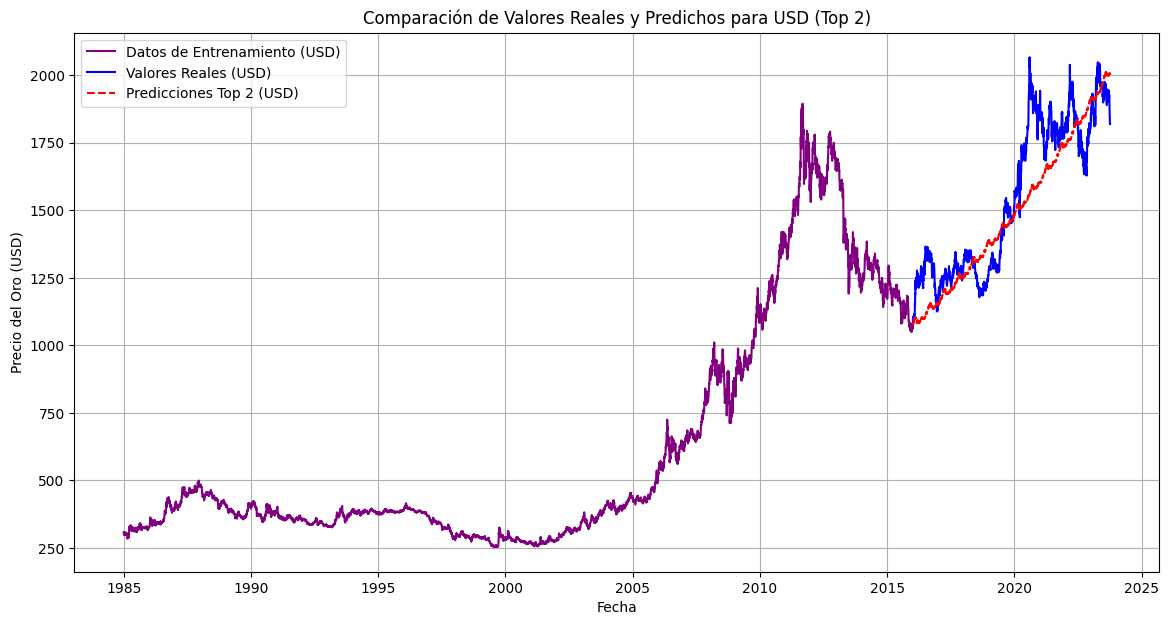

Resultados benchmark:
  RMSE: 131.34393339956452
  MAE: 103.54988270423313
  MAPE: 6.669229186654182%



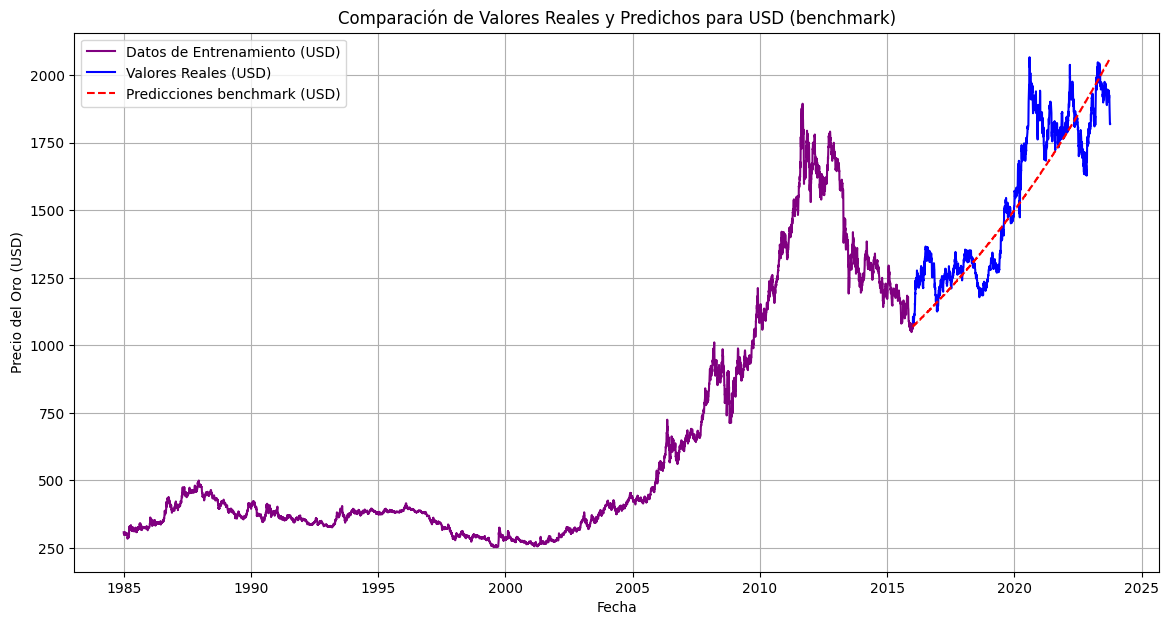

In [23]:

logging.captureWarnings(True)

# Comparativo combinaciones de alpha, beta y gamma
top_models = [
    {'alpha': 0.995, 'beta': 0.0001, 'gamma': 0.0001, 'seasonal_period': 800, 'label': 'Top 1'},
    {'alpha': 0.9596, 'beta': 0.0001, 'gamma': 0.0323, 'seasonal_period': 150, 'label': 'Top 2'},
    {'alpha': 0.23, 'beta': 0.12, 'gamma': 0, 'seasonal_period': 31, 'label': 'benchmark'}
]

# Establecer 'Date' como índice para el análisis de HW
daily_gold_rate_hs_seasonal = daily_gold_rate_benchmark.copy()
daily_gold_rate_hs_seasonal.set_index('Date', inplace=True)

# Establecer la frecuencia del índice como diaria
daily_gold_rate_hs_seasonal.index = pd.to_datetime(daily_gold_rate_hs_seasonal.index)
daily_gold_rate_hs_seasonal = daily_gold_rate_hs_seasonal.asfreq('B')  # Días hábiles


# División del conjunto de datos en entrenamiento y prueba
train_size_hs_seasonal = int(len(daily_gold_rate_hs_seasonal) * 0.8)
train_data_hs_seasonal = daily_gold_rate_hs_seasonal[:train_size_hs_seasonal]
test_data_hs_seasonal = daily_gold_rate_hs_seasonal[train_size_hs_seasonal:]

# Función para ejecutar el modelo, calcular métricas y graficar resultados
def ejecutar_modelo_final(alpha, beta, gamma, seasonal_period, currency_data, test_data, label):
    # Entrenar el modelo
    model = ExponentialSmoothing(currency_data, trend='mul', seasonal='add', seasonal_periods=seasonal_period).fit(
        smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
    predictions = model.forecast(len(test_data))

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mae = mean_absolute_error(test_data, predictions)
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    # Imprimir las métricas
    print(f"Resultados {label}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  MAPE: {mape}%\n")

    # Graficar los resultados
    plt.figure(figsize=(14, 7))
    plt.plot(currency_data.index, currency_data, label='Datos de Entrenamiento (USD)', color='purple')
    plt.plot(test_data.index, test_data, label='Valores Reales (USD)', color='blue')
    plt.plot(test_data.index, predictions, label=f'Predicciones {label} (USD)', color='red', linestyle='dashed')
    plt.xlabel('Fecha')
    plt.ylabel('Precio del Oro (USD)')
    plt.title(f'Comparación de Valores Reales y Predichos para USD ({label})')
    plt.legend()
    plt.grid()
    plt.show()

# Ejecutar el modelo final para los mejores parámetros
for model_params in top_models:
    ejecutar_modelo_final(
        alpha=model_params['alpha'],
        beta=model_params['beta'],
        gamma=model_params['gamma'],
        seasonal_period=model_params['seasonal_period'],
        currency_data=train_data_hs_seasonal['USD'],
        test_data=test_data_hs_seasonal['USD'],
        label=model_params['label']
    )


## Interpretación de los Resultados de los Modelos Estacionales y Benchmark

Los gráficos y las métricas obtenidas para los dos modelos estacionales con mejor desempeño , y el **modelo benchmark** sin componente estacional permiten hacer una comparación clara del rendimiento predictivo de cada modelo. A continuación, se detallan las observaciones clave:

### Interpretación de los Resultados:

  - Los valores de **MAPE** para los tres modelos son muy similares, con diferencias mínimas. El **modelo benchmark** y el **Top 1** presentan un rendimiento casi idéntico, con una ligera ventaja en **MAE** y **MAPE** para el **benchmark**.
  - En términos de **RMSE** y **MAE**, el **Top 1** y el **benchmark** están casi empatados, mientras que el **Top 2** presenta un error ligeramente mayor. Esto indica que la estacionalidad no ha logrado mejorar el ajuste considerablemente en comparación con el modelo sin estacionalidad.
  
### Análisis Gráfico :

- Los tres gráficos muestran que los modelos logran capturar correctamente la **tendencia general** de los precios del oro, pero no son capaces de reflejar con precisión las **fluctuaciones de corto plazo**. En todos los casos, las predicciones muestran una línea suave que sigue el aumento de los precios, pero no logran ajustarse a las variaciones más rápidas o abruptas.
- La gráfica del **Top 1** presenta un comportamiento muy similar al del **benchmark**, lo que refuerza los resultados numéricos: ambos modelos capturan la tendencia general de manera casi idéntica.

El **modelo benchmark** sin estacionalidad y los modelos etsacionales muestran un rendimiento prácticamente igual, con diferencias marginales en las métricas de error. Esto confirma que la inclusión de un componente estacional no mejora significativamente la precisión del modelo para los precios del oro, ya que no se observan patrones estacionales claros en el comportamiento de los datos. Aunque se probaron varios periodos estacionales, la tendencia a largo plazo parece ser el principal factor que influye en las predicciones con poca o ninguna mejora al añadir estacionalidad.

## Conclusión General del Modelo Holt-Winters para los Precios del Oro

- El **modelo Holt-Winters** demostró ser efectivo para capturar la **tendencia general** de los precios del oro en **USD** y **EUR**, mostrando mejoras significativas respecto al modelo **Suavizado Exponencial (ES)**. Sin embargo, los resultados evidenciaron que la inclusión de un **componente estacional** no aportó mejoras notables en la precisión predictiva.

- En términos de métricas como **RMSE**, **MAE**, y **MAPE**, los modelos estacionales lograron rendimientos similares al modelo sin estacionalidad, lo que refuerza la conclusión de que el comportamiento de los precios del oro no muestra un patrón estacional claro. La estacionalidad, aunque fue probada con diversos periodos, mostró un **impacto mínimo** en las predicciones.

- El modelo es adecuado para capturar la **tendencia a largo plazo**, pero sigue presentando dificultades para reflejar las **fluctuaciones de corto plazo** o **volatilidad** en los precios tal como el modelo **ES**. Este comportamiento sugiere que, para mejorar la precisión en el pronóstico del oro, sería recomendable explorar modelos más capaces de reaccionar a cambios abruptos y a la volatilidad del mercado.

## Introducción al Modelo ARIMA

El modelo **ARIMA** (Autoregressive Integrated Moving Average) es uno de los métodos de referencia para el análisis de series temporales sin estacionalidad. Este modelo es adecuado para series temporales donde la relación entre los datos está determinada por su estructura autoregresiva (AR) y de media móvil (MA), permitiendo además un proceso de integración (I) para transformar datos no estacionarios en una serie estacionaria.

Dado que nuestra serie de precios del oro no es estacionaria, el modelo **ARIMA** se implementará con un paso previo de diferenciación para estabilizar la media y cumplir con este requisito. El análisis de los valores de **p** (autoregresión), **d** (diferenciación), y **q** (media móvil) se determinará a partir de:

- **Prueba de Dickey-Fuller Aumentada (ADF)**: Evaluación de la estacionariedad de la serie.
- **Gráficos ACF y PACF**: Identificación de los posibles valores para **p** y **q** que describen las relaciones autorregresivas y de media móvil en la serie.

Este proceso permitirá optimizar los parámetros de **ARIMA** para capturar las características más significativas de los precios del oro y maximizar la precisión del modelo predictivo en nuestra base de datos.


# Implementación del Modelo ARIMA para Predicción de Precios del Oro

El modelo **ARIMA** se utiliza en series temporales para realizar predicciones basadas en patrones y tendencias observadas en datos históricos. Este modelo es adecuado para series que no muestran estacionalidad, como en nuestro caso. Para la implementación de este modelo, los datos deben cumplir con el criterio de estacionariedad, un requisito esencial en modelos de series temporales.

Dado que los precios del oro han mostrado **no estacionaridad** en nuestro análisis exploratorio, el modelo **ARIMA** se aplicará después de una diferenciación de la serie, ajustando sus parámetros para capturar mejor la tendencia y las fluctuaciones del precio a lo largo del tiempo.

Los componentes a optimizar del ARIMA son:

- **Componente AR (AutoRegressive order - p)**
- **Componente I (Integrated order - d)**
- **Componente MA (Moving Average order - q)**

## Transformación en la Serie de Precios del Oro

Dado que los precios del oro no presentan **estacionariedad** en su comportamiento , es necesario realizar una **transformación** en los datos para que cumplan con este criterio, ya que este es fundamental en modelos como **ARIMA**. La **diferenciación** será aplicada para estabilizar la media y eliminar tendencias a largo plazo, permitiendo que el modelo capture con mayor precisión las fluctuaciones en la serie temporal.

Este proceso ajustará los datos para hacerlos más adecuados al análisis y modelado, facilitando una mejor identificación de patrones.

### Aplicacion de Transformación con difrenciacion

Pruebas Dickey-Fuller antes de la transformación:

USD (Antes):
Estadístico ADF: 0.08926533923192043
p-valor: 0.965320500541408
Valores críticos: {'1%': -3.430999291944839, '5%': -2.8618269486484413, '10%': -2.566922737625234}
La serie NO es estacionaria

EUR (Antes):
Estadístico ADF: 1.0861413502132413
p-valor: 0.9950965917581289
Valores críticos: {'1%': -3.430999291944839, '5%': -2.8618269486484413, '10%': -2.566922737625234}
La serie NO es estacionaria

Pruebas Dickey-Fuller después de la primera diferenciación:

USD (Después):
Estadístico ADF: -16.96652695649502
p-valor: 9.225551498256222e-30
Valores críticos: {'1%': -3.430999356419923, '5%': -2.8618269771395015, '10%': -2.5669227527910543}
La serie es estacionaria

EUR (Después):
Estadístico ADF: -16.983182181848544
p-valor: 8.981056153911323e-30
Valores críticos: {'1%': -3.430999291944839, '5%': -2.8618269486484413, '10%': -2.566922737625234}
La serie es estacionaria



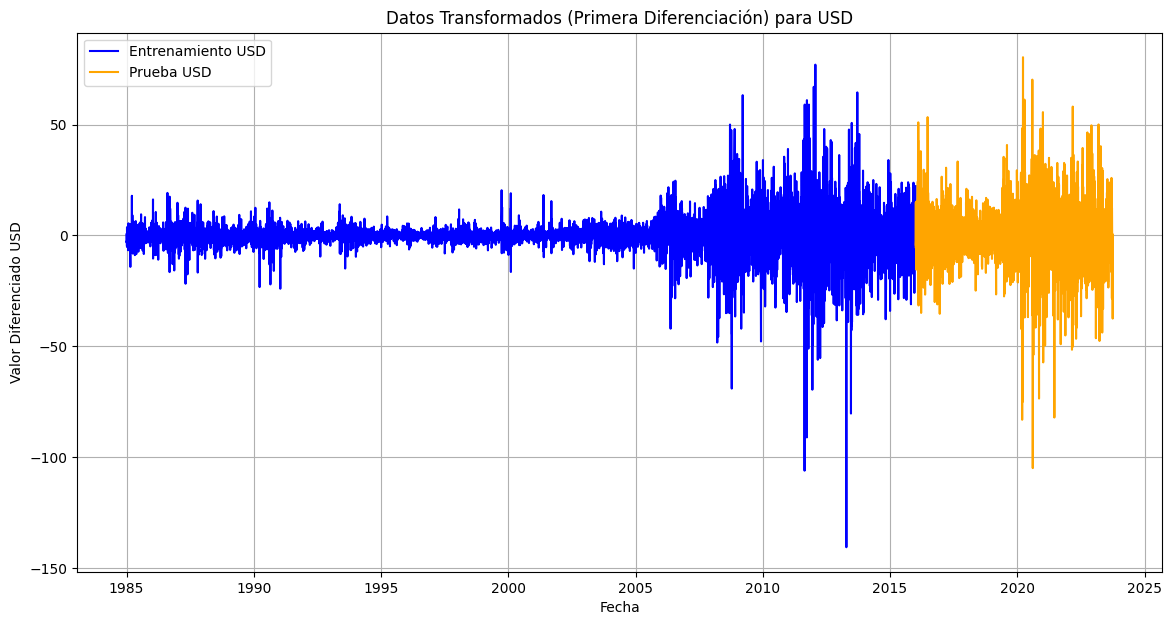

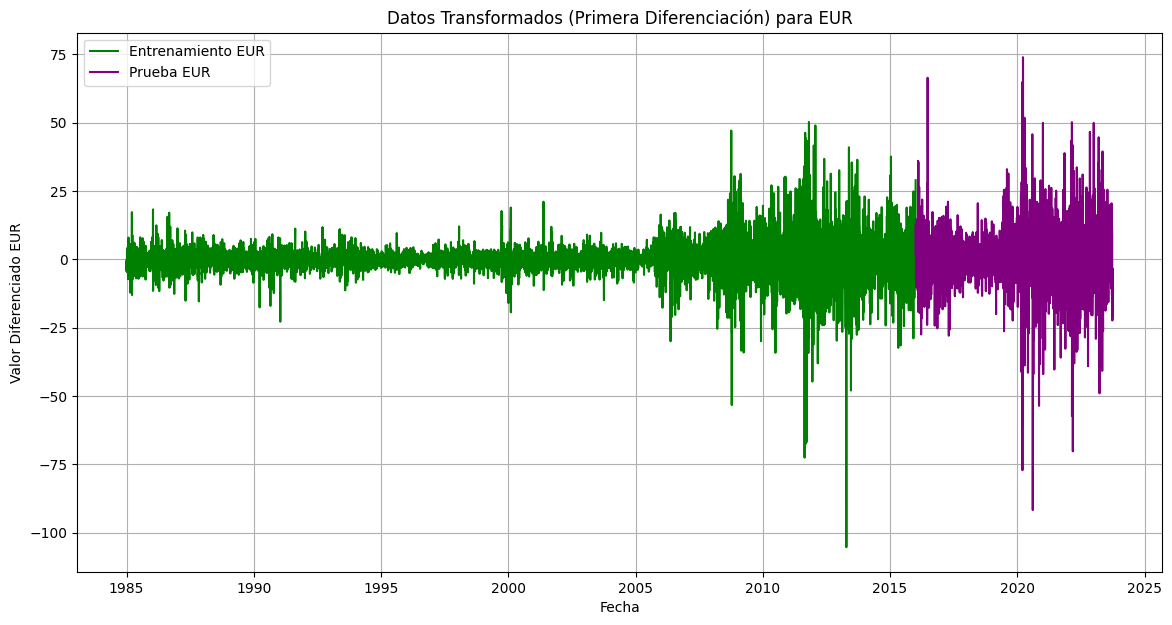

In [20]:
# Importar librerías necesarias
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Crear copia de los datos originales
daily_gold_rate_AR = daily_gold_rate_benchmark[['Date', 'USD', 'EUR']].copy()
daily_gold_rate_AR.set_index('Date', inplace=True)

# Prueba Dickey-Fuller antes de la transformación
print("Pruebas Dickey-Fuller antes de la transformación:\n")

adf_test_usd_before = adfuller(daily_gold_rate_AR['USD'])
print("USD (Antes):")
print(f"Estadístico ADF: {adf_test_usd_before[0]}")
print(f"p-valor: {adf_test_usd_before[1]}")
print(f"Valores críticos: {adf_test_usd_before[4]}")
if adf_test_usd_before[1] <= 0.05:
    print("La serie es estacionaria\n")
else:
    print("La serie NO es estacionaria\n")

adf_test_eur_before = adfuller(daily_gold_rate_AR['EUR'])
print("EUR (Antes):")
print(f"Estadístico ADF: {adf_test_eur_before[0]}")
print(f"p-valor: {adf_test_eur_before[1]}")
print(f"Valores críticos: {adf_test_eur_before[4]}")
if adf_test_eur_before[1] <= 0.05:
    print("La serie es estacionaria\n")
else:
    print("La serie NO es estacionaria\n")

# Aplicar primera diferenciación sin transformación logarítmica
daily_gold_rate_AR['USD_diff'] = daily_gold_rate_AR['USD'].diff().dropna()
daily_gold_rate_AR['EUR_diff'] = daily_gold_rate_AR['EUR'].diff().dropna()

# Prueba Dickey-Fuller después de la diferenciación
print("Pruebas Dickey-Fuller después de la primera diferenciación:\n")

adf_test_usd_after = adfuller(daily_gold_rate_AR['USD_diff'].dropna())
print("USD (Después):")
print(f"Estadístico ADF: {adf_test_usd_after[0]}")
print(f"p-valor: {adf_test_usd_after[1]}")
print(f"Valores críticos: {adf_test_usd_after[4]}")
if adf_test_usd_after[1] <= 0.05:
    print("La serie es estacionaria\n")
else:
    print("La serie NO es estacionaria\n")

adf_test_eur_after = adfuller(daily_gold_rate_AR['EUR_diff'].dropna())
print("EUR (Después):")
print(f"Estadístico ADF: {adf_test_eur_after[0]}")
print(f"p-valor: {adf_test_eur_after[1]}")
print(f"Valores críticos: {adf_test_eur_after[4]}")
if adf_test_eur_after[1] <= 0.05:
    print("La serie es estacionaria\n")
else:
    print("La serie NO es estacionaria\n")

# División de los datos transformados en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(daily_gold_rate_AR.dropna()) * 0.8)
train_data_usd_AR = daily_gold_rate_AR['USD_diff'][:train_size]
test_data_usd_AR = daily_gold_rate_AR['USD_diff'][train_size:]
train_data_eur_AR = daily_gold_rate_AR['EUR_diff'][:train_size]
test_data_eur_AR = daily_gold_rate_AR['EUR_diff'][train_size:]

# Visualización de los datos transformados para USD 
plt.figure(figsize=(14, 7))
plt.plot(train_data_usd_AR.index, train_data_usd_AR, label='Entrenamiento USD', color='blue')
plt.plot(test_data_usd_AR.index, test_data_usd_AR, label='Prueba USD', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Valor Diferenciado USD')
plt.title('Datos Transformados (Primera Diferenciación) para USD')
plt.legend()
plt.grid()
plt.show()

# Visualización de los datos transformados para EUR 
plt.figure(figsize=(14, 7))
plt.plot(train_data_eur_AR.index, train_data_eur_AR, label='Entrenamiento EUR', color='green')
plt.plot(test_data_eur_AR.index, test_data_eur_AR, label='Prueba EUR', color='purple')
plt.xlabel('Fecha')
plt.ylabel('Valor Diferenciado EUR')
plt.title('Datos Transformados (Primera Diferenciación) para EUR')
plt.legend()
plt.grid()
plt.show()


## Resultados de la Transformación Logarítmica con Diferenciación

Después de aplicar la transformación logarítmica a los datos de precios del oro en **USD** y **EUR**, se verificó la estacionariedad mediante la prueba **Dickey-Fuller Aumentada (ADF)**. Los resultados confirmaron que la serie temporal original no era estacionaria como se observó en el **EDA**, pero tras la transformación, ambas series (USD y EUR) se convirtieron exitosamente en estacionarias, lo cual es necesario para proceder con el modelo **ARIMA**.

### Observaciones
- Se aprecia una disminución significativa en la tendencia de largo plazo.
- Los resultados de la prueba **Dickey-Fuller** confirman que las series son ahora estacionarias.


## Gráficos ACF y PACF
Los gráficos de **Autocorrelación (ACF)** y **Autocorrelación Parcial (PACF)** permiten identificar los potenciales valores de los componentes `p` y `q` del modelo **ARIMA**. 

- El gráfico de **ACF** ayuda a identificar el componente de **media móvil (q)** al mostrar la correlación entre un valor y sus lags.
- El gráfico de **PACF** es útil para determinar el número de lags en el componente **autorregresivo (p)**.

### Visualizacion de Gráficos ACF y PACF

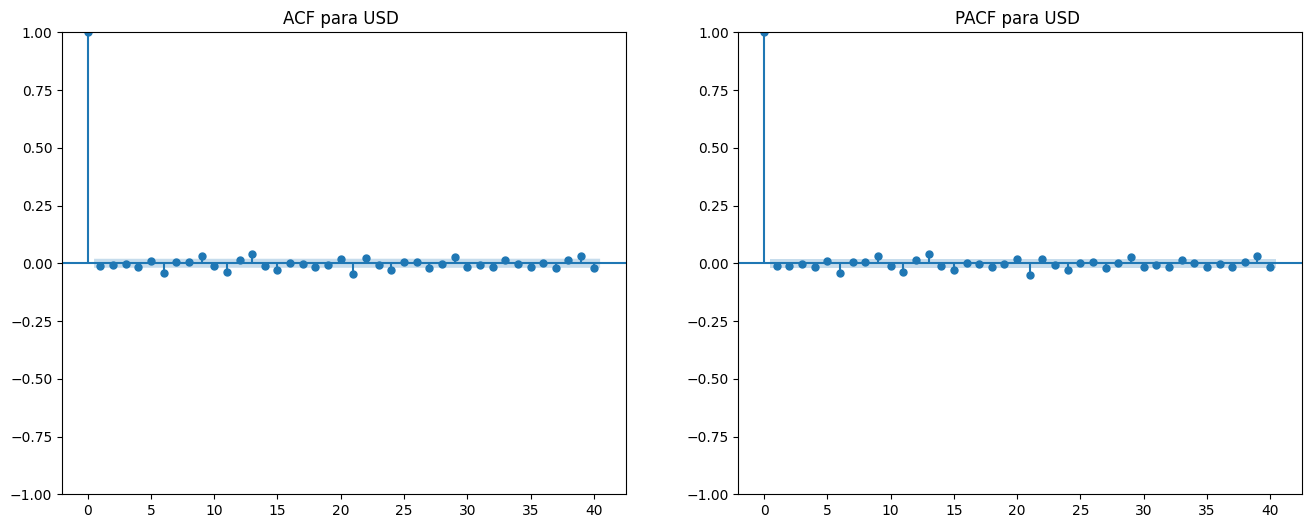

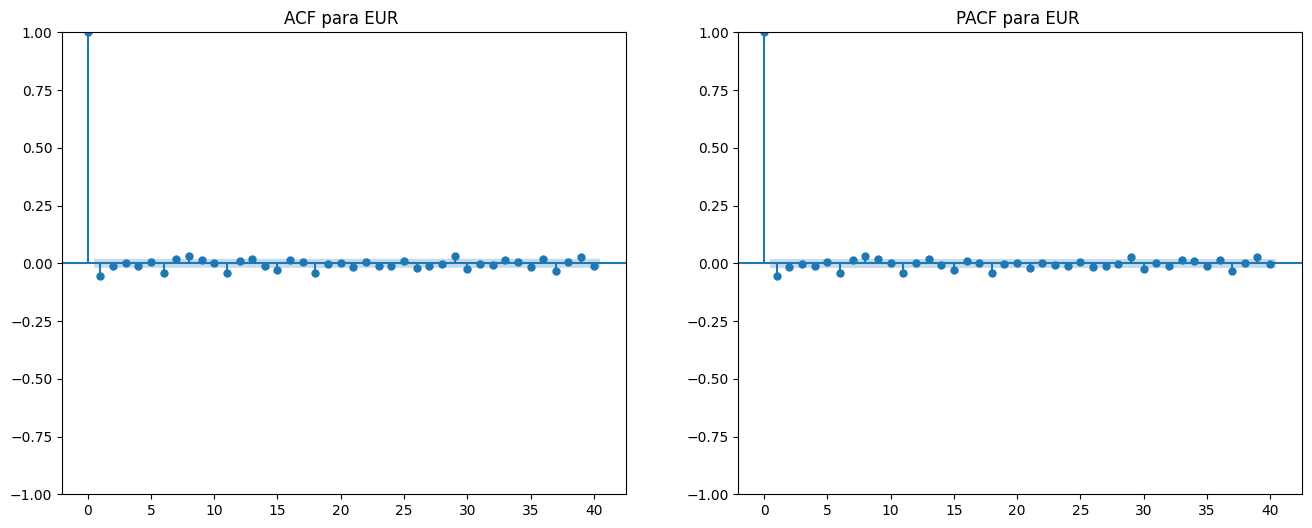

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico ACF y PACF para USD transformado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(daily_gold_rate_AR['USD_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('ACF para USD ')

plot_pacf(daily_gold_rate_AR['USD_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('PACF para USD ')

plt.show()

# Gráfico ACF y PACF para EUR transformado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(daily_gold_rate_AR['EUR_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('ACF para EUR ')

plot_pacf(daily_gold_rate_AR['EUR_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('PACF para EUR ')

plt.show()


## Interpretación de las Gráficas ACF y PACF

En los gráficos de **ACF** y **PACF** se observa lo siguiente:

- **ACF**: La autocorrelación en el retardo 0 es alta, pero decrece  partir del primer retardo, estabilizándose cerca de cero. Esto indica que no existe una autocorrelación significativa en retardos mas alla del primero.
  
- **PACF**: La función de autocorrelación parcial muestra un corte abrupto después del primer retardolo que como en que este modelo podria ser representado por un retardo simple.

## Parámetros Iniciales del Modelo ARIMA

- **p (Orden Autorregresivo)**: Para este parametro incial **p = 1** parece ser indicado ya que PACF muestra un corte abrupto en el primer retardo.
  
- **q (Orden de Media Móvil)**: El gráfico ACF indica que un valor de **q = 1** es adecuado, debido a la caída brusca en el primer retardo.
  
- **d (Diferenciación)**: La serie se volvió estacionaria después de una diferenciación simple, por lo que se utilizará **d = 1**.

### Optimizacion de parametros Modelo ARIMA

A partir de los parámetros iniciales identificados (**p = 1**, **d = 1**, **q = 1**), se utilizó un **grid search** para optimizar el modelo mediante la métrica **AIC**. Este proceso exploró diferentes combinaciones de los parametros buscando reducir el **AIC** y encontrar el modelo que mejor se ajusta a los datos.

In [24]:

from statsmodels.tsa.arima.model import ARIMA
import logging

logging.captureWarnings(True)

# Parámetros iniciales para el Grid Search
# Parámetros más amplios para Grid Search
p_values = [0, 1, 2, 3, 4, 5]
d_values = [1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Función para entrenar el modelo ARIMA y devolver el AIC
def evaluate_arima_model_aic(train_data, arima_order):
    model = ARIMA(train_data, order=arima_order)
    model_fit = model.fit()
    return model_fit.aic

# Uso de TQDM para seguimiento del proceso con la función Grid Search optimizada
def grid_search_with_progress_aic(train_data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    total_iterations = len(p_values) * len(d_values) * len(q_values)
    with tqdm(total=total_iterations, desc="Grid Search Progress (AIC)") as pbar:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p, d, q)
                    try:
                        aic = evaluate_arima_model_aic(train_data, order)
                        if aic < best_score:
                            best_score, best_cfg = aic, order
                        pbar.update(1)  # Actualizar barra de progreso
                    except:
                        pbar.update(1)  # Actualizar incluso si hay error
                        continue
    return best_cfg, best_score

# Ejecución con paralelización en 16 núcleos y monitorización con TQDM
with parallel_backend('threading', n_jobs=16):
    best_order_usd, best_aic_usd = grid_search_with_progress_aic(train_data_usd_AR, p_values, d_values, q_values)
    best_order_eur, best_aic_eur = grid_search_with_progress_aic(train_data_eur_AR, p_values, d_values, q_values)

# Mostrar los mejores resultados obtenidos para USD y EUR
print(f"Mejor ARIMA para USD (AIC): {best_order_usd} con AIC={best_aic_usd:.3f}")
print(f"Mejor ARIMA para EUR (AIC): {best_order_eur} con AIC={best_aic_eur:.3f}")


Grid Search Progress (AIC): 100%|██████████| 72/72 [04:41<00:00,  3.90s/it]

Mejor ARIMA para USD (AIC): (3, 1, 4) con AIC=57568.977
Mejor ARIMA para EUR (AIC): (3, 1, 5) con AIC=52902.901


### Interpretación de los Resultados del Modelo ARIMA para USD y EUR

La optimización del modelo **ARIMA** utilizando **Grid Search** resultó en los siguientes parámetros para los precios del oro en **USD** y **EUR**:

- **USD: ARIMA(3, 1, 4)**
  - **p = 3**: La inclusión de este componente autoregresivo sugiere una dependencia en el tiempo que captura la estructura de los precios recientes, permitiendo al modelo incorporar la memoria de corto plazo en las predicciones.
  - **d = 1**: La diferenciación de primer orden aplicada previamente ha estabilizado la media de la serie, haciendo que el modelo capture mejor las fluctuaciones al eliminar las tendencias a largo plazo.
  - **q = 4**: La inclusión de cuatro términos de media móvil indica que el modelo ajusta las predicciones considerando los errores de predicción de los últimos cuatro periodos suavizando la volatilidad de los datos.

- **EUR: ARIMA(3, 1, 5)**
  - **q = 5**: La inclusión de cinco términos de media móvil sugiere que el modelo en **EUR** depende de una corrección más detallada en función de los errores de predicción recientes lo que en teoria permitira una mejor precisión en periodos de alta volatilidad.

#### Comparación de los Resultados

- **AIC para USD y EUR**:
  - El **AIC** del modelo **EUR** (52902.901) es menor que el de **USD** (57568.977), lo que indica que el modelo en **EUR** tiene un mejor ajuste en comparación con el de **USD**.

### Entrenamiento, Evaluación y Visualización de los Modelos ARIMA

Para evaluar los modelos **ARIMA(3, 1, 4)USD** y **ARIMA(3, 1, 5)EUR**, se entrenarán ambos modelos. Posteriormente, se generarán predicciones sobre el conjunto de prueba, y se calcularán las métricas de error **RMSE**, **MAPE** y **MAE** para cuantificar el desempeño predictivo de cada modelo. Finalmente, se graficarán las predicciones en comparación con los datos reales para observar visualmente la precisión y el ajuste del modelo.

USD - RMSE: 441.130, MAE: 375.101, MAPE: 22.283%


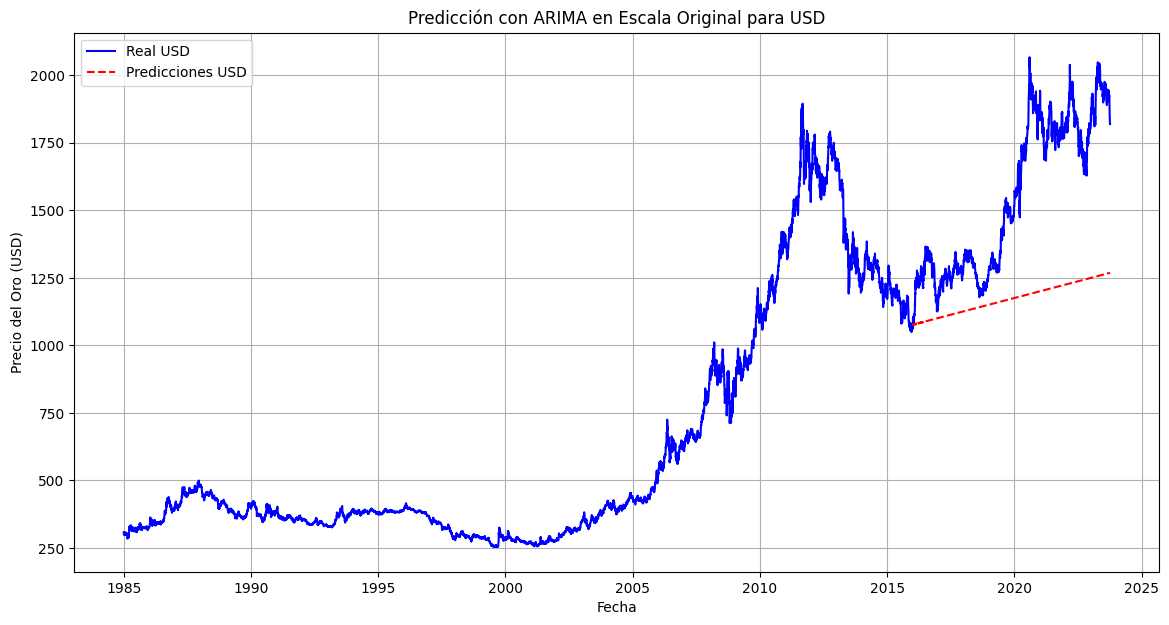

EUR - RMSE: 378.362, MAE: 303.197, MAPE: 19.606%


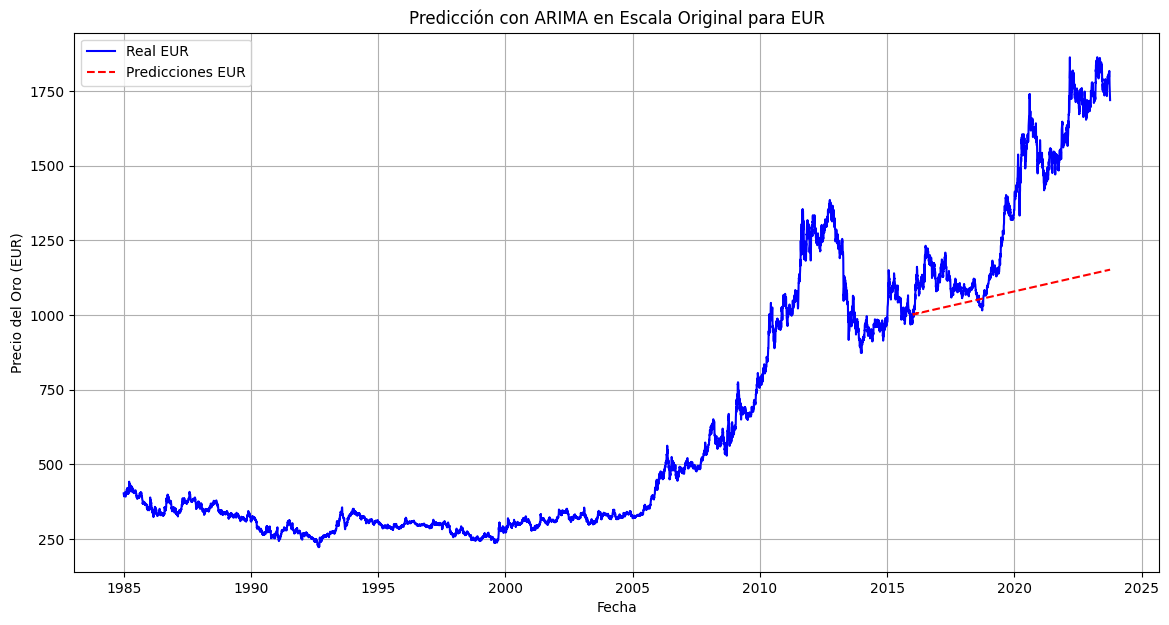

In [31]:
# Definir el tamaño de entrenamiento (80%) para dividir los datos
train_size = int(len(daily_gold_rate_AR) * 0.8)

# Datos diferenciados y originales de entrenamiento y prueba para USD
train_data_usd_AR = daily_gold_rate_AR['USD_diff'][:train_size]
test_data_usd_AR = daily_gold_rate_AR['USD_diff'][train_size:]
train_data_usd_orig = daily_gold_rate_AR['USD'][:train_size]
test_data_usd_orig = daily_gold_rate_AR['USD'][train_size:]

# Datos diferenciados y originales de entrenamiento y prueba para EUR
train_data_eur_AR = daily_gold_rate_AR['EUR_diff'][:train_size]
test_data_eur_AR = daily_gold_rate_AR['EUR_diff'][train_size:]
train_data_eur_orig = daily_gold_rate_AR['EUR'][:train_size]
test_data_eur_orig = daily_gold_rate_AR['EUR'][train_size:]

# Parámetros optimizados para ARIMA según el AIC
best_order_usd = (3, 1, 4)
best_order_eur = (3, 1, 5)

# Función para entrenar, predecir y devolver la predicción a la escala original
def forecast_arima_original(train_data_diff, test_data_diff, original_data, order, currency):
    # Ajustar el modelo ARIMA
    model = ARIMA(train_data_diff, order=order)
    model_fit = model.fit()

    # Predicciones en la serie diferenciada
    predictions_diff = model_fit.forecast(steps=len(test_data_diff))

    # Reconstruir la predicción en la escala original
    last_value_orig = original_data.iloc[-len(test_data_diff) - 1]  # Último valor original antes del conjunto de prueba
    predictions_original_scale = last_value_orig + predictions_diff.cumsum()

    # Calcular RMSE, MAE, MAPE en la escala original
    rmse = np.sqrt(mean_squared_error(original_data[-len(test_data_diff):], predictions_original_scale))
    mae = mean_absolute_error(original_data[-len(test_data_diff):], predictions_original_scale)
    mape = np.mean(np.abs((original_data[-len(test_data_diff):] - predictions_original_scale) / original_data[-len(test_data_diff):])) * 100

    print(f'{currency} - RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}%')

    # Graficar las predicciones
    plt.figure(figsize=(14, 7))
    plt.plot(original_data.index, original_data, label=f'Real {currency}', color='blue')
    plt.plot(test_data_diff.index, predictions_original_scale, label=f'Predicciones {currency}', color='red', linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel(f'Precio del Oro ({currency})')
    plt.title(f'Predicción con ARIMA en Escala Original para {currency}')
    plt.legend()
    plt.grid()
    plt.show()

# Ejecutar la predicción para USD
forecast_arima_original(train_data_usd_AR, test_data_usd_AR, daily_gold_rate_AR['USD'], best_order_usd, 'USD')

# Ejecutar la predicción para EUR
forecast_arima_original(train_data_eur_AR, test_data_eur_AR, daily_gold_rate_AR['EUR'], best_order_eur, 'EUR')


### Interpretación de los Resultados del Modelo ARIMA para USD y EUR

Después de entrenar los modelos **ARIMA(3, 1, 4)** para **USD** y **ARIMA(3, 1, 5)** para **EUR**, se obtuvieron las siguientes métricas de error:

- **USD**:
  - **RMSE**: 441.130
  - **MAE**: 375.101
  - **MAPE**: 22.283%
  
- **EUR**:
  - **RMSE**: 378.362
  - **MAE**: 303.197
  - **MAPE**: 19.606%

### Análisis Comparativo con el Modelo Holt-Winters

Al comparar estos resultados con los obtenidos previamente con el **modelo Holt-Winters**, es evidente que el desempeño del **ARIMA** es inferior. Los valores de **RMSE**, **MAE** y **MAPE** son considerablemente más altos en **ARIMA** que en **Holt-Winters**, lo que indica que el modelo **ARIMA** tiene mayores errores de predicción y no logra ajustarse correctamente a la serie temporal.

- **MAPE**: El valor de **MAPE** del 22.283% para **USD** y 19.606% para **EUR** en el modelo **ARIMA** es significativamente mayor en comparación con el modelo **Holt-Winters**, donde los valores eran alrededor del 6.69% y 6.50%, respectivamente. Esto sugiere que **ARIMA** tiene dificultades para seguir la tendencia general de los precios del oro en ambas divisas, y su precisión en las predicciones es notablemente menor.

### Falta de Ajuste a la Tendencia

-Las gráficas generadas también refuerzan este punto: las **predicciones de ARIMA** no siguen de manera efectiva la **tendencia ascendente** de los datos reales mostrando una línea de predicción casi plana que no reflejan el crecimiento observada en los precios reales.
-Este comportamiento puede deberse a que el modelo **ARIMA** no está capturando adecuadamente la **tendencia a largo plazo** presente en los precios del oro, lo que es más evidente en las **gráficas** tanto para **USD** como para **EUR**.

### Optimización del Modelo ARIMA mediante Grid Search basado en RMSE

Con el fin de mejorar la precisión y el ajuste del modelo **ARIMA**, se realizara un **Grid Search** para optimizar el modelo utilizando el **RMSE** como métrica de evaluación.Buscando un modelo mas indicado para reflejar las tendecias de los precios del oro.


In [27]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go


# Ignorar warnings de convergencia
warnings.filterwarnings("ignore")

# Usar las variables ya definidas para diferenciación y división de los datos
train_usd_diff = daily_gold_rate_AR['USD_diff'].iloc[:-int(len(daily_gold_rate_AR) * 0.2)]
test_usd_diff = daily_gold_rate_AR['USD_diff'].iloc[-int(len(daily_gold_rate_AR) * 0.2):]

train_eur_diff = daily_gold_rate_AR['EUR_diff'].iloc[:-int(len(daily_gold_rate_AR) * 0.2)]
test_eur_diff = daily_gold_rate_AR['EUR_diff'].iloc[-int(len(daily_gold_rate_AR) * 0.2):]

train_usd_original = daily_gold_rate_AR['USD'].iloc[:-int(len(daily_gold_rate_AR) * 0.2)]
test_usd_original = daily_gold_rate_AR['USD'].iloc[-int(len(daily_gold_rate_AR) * 0.2):]

train_eur_original = daily_gold_rate_AR['EUR'].iloc[:-int(len(daily_gold_rate_AR) * 0.2)]
test_eur_original = daily_gold_rate_AR['EUR'].iloc[-int(len(daily_gold_rate_AR) * 0.2):]

# Definir los rangos de parámetros para (p, d, q)
p = range(0, 5)
d = range(1, 2)  
q = range(0, 5)

# Función para buscar los mejores parámetros para una serie dada usando AIC
def optimize_arima(series, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except:
                    continue
    return best_order, best_aic, best_model

# Optimizar ARIMA para la serie de USD diferenciada
best_order_usd, best_aic_usd, best_model_usd = optimize_arima(train_usd_diff, p, d, q)
print(f"Mejores parámetros para USD: {best_order_usd} con AIC = {best_aic_usd}")

# Optimizar ARIMA para la serie de EUR diferenciada
best_order_eur, best_aic_eur, best_model_eur = optimize_arima(train_eur_diff, p, d, q)
print(f"Mejores parámetros para EUR: {best_order_eur} con AIC = {best_aic_eur}")

# Entrenar el modelo ARIMA con los mejores parámetros y hacer predicciones
forecasts_usd_diff_optimized = best_model_usd.forecast(steps=len(test_usd_diff))
forecasts_eur_diff_optimized = best_model_eur.forecast(steps=len(test_eur_diff))

# Invertir la diferenciación para obtener las predicciones en la escala original
forecasts_usd_optimized = np.cumsum(forecasts_usd_diff_optimized) + train_usd_original.iloc[-1]
forecasts_eur_optimized = np.cumsum(forecasts_eur_diff_optimized) + train_eur_original.iloc[-1]

# Calcular el RMSE para USD
rmse_usd = np.sqrt(mean_squared_error(test_usd_original, forecasts_usd_optimized))
print(f"RMSE para USD: {rmse_usd}")

# Calcular el RMSE para EUR
rmse_eur = np.sqrt(mean_squared_error(test_eur_original, forecasts_eur_optimized))
print(f"RMSE para EUR: {rmse_eur}")

# Función para graficar los resultados
def plot_forecasts(train, test, forecasts, title, y_title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train, name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test, name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Fecha',
                      yaxis_title=y_title)
    fig.show()

# Graficar los pronósticos optimizados para USD
plot_forecasts(train_usd_original, test_usd_original, forecasts_usd_optimized, 'ARIMA Optimizado - USD', 'Precio del Oro (USD)')

# Graficar los pronósticos optimizados para EUR
plot_forecasts(train_eur_original, test_eur_original, forecasts_eur_optimized, 'ARIMA Optimizado - EUR', 'Precio del Oro (EUR)')


Mejores parámetros para USD: (3, 1, 4) con AIC = 57584.22780839961
Mejores parámetros para EUR: (4, 1, 4) con AIC = 52916.84108508153
RMSE para USD: 426.2312264510948
RMSE para EUR: 366.68817807815617


### Interpretación de los Resultados del ARIMA Optimizado para USD y EUR

El proceso de **Grid Search** utilizando **RMSE** como métrica de optimización resultó en los siguientes parámetros para los modelos **ARIMA** de **USD** y **EUR**:

- **Mejores Parámetros para USD**: ARIMA(3, 1, 4) con un **AIC** de 57584.23
- **Mejores Parámetros para EUR**: ARIMA(4, 1, 4) con un **AIC** de 52916.84

- **USD: ARIMA(3, 1, 4)**:
 El ajuste del modelo ha mejorado ligeramente, pero el **AIC** sigue siendo elevado, lo que sugiere que, aunque el modelo se ajusta mejor que en iteraciones anteriores, aún tiene dificultades para capturar la totalidad de la estructura de los datos.

- **EUR: ARIMA(4, 1, 4)**:
  -  La diferenciación de primer orden (**d = 1**) continúa siendo clave para estabilizar la serie. Con un **AIC** de 52916.84 y un **RMSE** de 366.69, este modelo sigue ajustándose mejor a los datos en comparación con el modelo de **USD**, pero los resultados son lejanos a ser optimos.

### Comparación y Rendimiento

- **Comparación de RMSE**: 
  - El **RMSE** del modelo optimizado para **USD** (426.23) y para **EUR** (366.69) indica una ligera mejora con respecto a los valores obtenidos anteriormente, pero las predicciones siguen estando por debajo del rendimiento observado con otros modelos, como **Holt-Winters**.
  - **EUR** sigue mostrando un mejor ajuste general, lo que sugiere que los precios del oro en **EUR** son más predecibles y menos volátiles que en **USD**.


### Conclusión Final del Modelo ARIMA

A pesar de la optimización realizada, los resultados muestran que el **modelo ARIMA** sigue teniendo dificultades para ajustar correctamente las series temporales de los precios del oro, especialmente en **USD**. Aunque el **RMSE** ha mejorado ligeramente, los modelos **ARIMA** no logran capturar las fluctuaciones y la tendencia a largo plazo de los datos a difrencia de otros enfoques como **Holt-Winters**. 

El modelo **ARIMA** subestima los precios del oro, especialmente en los periodos más recientes, lo que se refleja en las gráficas donde las predicciones no se alinean bien con los valores reales. Estos resultados sugieren que, aunque el **ARIMA** es un modelo útil para series temporales, su aplicación a estos datos no es la más efectiva.

## Implementación del Modelo de Redes Neuronales Artificiales (ANN) para Predicción de Precios del Oro

- Las **Redes Neuronales Artificiales (ANN)** son un enfoque popular para la predicción de series temporales debido a su capacidad de aprender patrones no lineales y complejos en los datos. Este modelo consiste en capas de neuronas interconectadas que procesan la información a través de funciones de activación, permitiendo  capturar patrones complejos en la tendecia a difrencia de modelos tradicionales como **ARIMA** o **Holt-Winters**.

- En este proceso, se implementará un modelo **ANN** utilizando los datos de precios del oro en **USD** y **EUR**, esperando comparar su desempeño con los otros modelos de benchmark previamente evaluados. Se entrenará el modelo utilizando llas series de tiempo y se evaluará su capacidad predictiva mediante métricas como **RMSE**, **MAE**, y **MAPE**, al igual que en los modelos anteriores.

### Preprocesamiento de Datos: Normalización de las Divisas USD y EUR

En esta fase, se realizara el preprocesamiento de los datos de las divisas **USD** y **EUR** mediante la **normalización**, una transformación esencial para preparar los datos de series temporales antes de su uso en redes neuronales artificiales (ANN).

1. **División en Conjuntos de Entrenamiento y Prueba**:
   - La serie completa se dividió en **80% para entrenamiento** y **20% para prueba**, garantizando que los datos recientes permanezcan en el conjunto de prueba para una evaluación futura más precisa del modelo.

2. **Normalización de las Series USD y EUR**:
   - La normalización se aplicó utilizando `MinMaxScaler`, ajustando ambos conjuntos (entrenamiento y prueba) al rango [0, 1]. Esta transformación contribuye a mejorar la estabilidad y precisión del modelo ANN al reducir la escala de los datos y permitir que el modelo aprenda de manera más eficiente.

Este preprocesamiento deja listos los datos de **USD** y **EUR** para la siguiente etapa de creación de secuencias de tiempo, fundamentales para entrenar adecuadamente el modelo ANN.



### Preprocesamiento de Datos: Normalización Conjunta de las Divisas USD y EUR

En esta fase, el preprocesamiento de los datos de las divisas **USD** y **EUR** se realizara mediante una **normalización conjunta**, ajustando ambos conjuntos de datos para mejorar la consistencia y precisión del modelo de redes neuronales artificiales (ANN) que predice una de las divisas usando ambas series.

1. **División en Conjuntos de Entrenamiento y Prueba**:
   - La serie completa se dividió en **80% para entrenamiento** y **20% para prueba** y esta sera usada para entrenar modelos para cada una de las divisas.

2. **Normalización Conjunta de las Series USD y EUR**:
   - La normalización se aplicó de forma conjunta utilizando `MinMaxScaler`, escalando ambas series al rango [0, 1]. Este enfoque asegura que ambas divisas se normalicen en el mismo rango, mejorando la estabilidad del modelo y permitiendo que este aprenda relaciones multivariadas de manera más eficiente al entrenar para predecir una divisa utilizando ambas series temporalmente alineadas.

Con este preprocesamiento, los datos de **USD** y **EUR** están listos para la siguiente fase de creación y optimizacion de secuencias de tiempo.


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Crear copia del dataset sin valores faltantes

# Ignorar warnings
warnings.filterwarnings("ignore")
daily_gold_rate_ANN = daily_gold_rate_benchmark[['Date', 'USD', 'EUR']].dropna().copy()


# Dividir los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size_ANN = int(len(daily_gold_rate_ANN) * 0.8)
train_data_ANN_og = daily_gold_rate_ANN[:train_size_ANN]
test_data_ANN_og = daily_gold_rate_ANN[train_size_ANN:]

# Dividir los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_data_ANN = daily_gold_rate_ANN[:train_size_ANN]
test_data_ANN = daily_gold_rate_ANN[train_size_ANN:]

# Normalización conjunta de USD y EUR en ambos conjuntos
scaler_ANN = MinMaxScaler()
train_data_ANN[['USD', 'EUR']] = scaler_ANN.fit_transform(train_data_ANN[['USD', 'EUR']])
test_data_ANN[['USD', 'EUR']] = scaler_ANN.transform(test_data_ANN[['USD', 'EUR']])

# Verificación de la normalización conjunta
print("Conjunto de entrenamiento normalizado (USD y EUR):")
print(train_data_ANN.head())

print("\nConjunto de prueba normalizado (USD y EUR):")
print(test_data_ANN.head())


2024-10-27 16:33:09.332072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730064789.347984  984859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730064789.352973  984859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 16:33:09.370979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Conjunto de entrenamiento normalizado (USD y EUR):
        Date       USD       EUR
0 1985-01-01  0.033796  0.154935
1 1985-01-02  0.032091  0.154110
2 1985-01-03  0.030142  0.150319
3 1985-01-04  0.030660  0.150379
4 1985-01-07  0.027676  0.146426

Conjunto de prueba normalizado (USD y EUR):
           Date       USD       EUR
8091 2016-01-06  0.510656  0.681268
8092 2016-01-07  0.519760  0.684508
8093 2016-01-08  0.517020  0.678870
8094 2016-01-11  0.516350  0.678560
8095 2016-01-12  0.507003  0.669750


/tmp/ipykernel_984859/1874422628.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ANN[['USD', 'EUR']] = scaler_ANN.fit_transform(train_data_ANN[['USD', 'EUR']])
/tmp/ipykernel_984859/1874422628.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_ANN[['USD', 'EUR']] = scaler_ANN.transform(test_data_ANN[['USD', 'EUR']])


### Optimización del Tamaño de la Ventana en el Modelo ANN

Este proceso se centra en determinar el tamaño de ventana óptimo en nuestro modelo de red neuronal artificial (ANN) para mejorar la precisión en la predicción de precios del oro. La estrategia aplicada incluye:

- **Construcción de Ventanas Temporales**: Mediante una función de ventanas, convertimos las serie en sub-secuencias que representan el comportamiento de los precios en períodos específicos. Este método nos permite estructurar los datos para capturar la tendencia de manera más precisa.

- **Optimización con del tamaño de ventanas**:Se configuro un proceso de búsqueda en el que se prueban diferentes tamaños de secuencias de tiempo (`window_size`) y se entrena el modelo ANN en cada iteración. En cada ejecución, se evalúa el rendimiento con **RMSE** sobre un conjunto de validación, permitiendo identificar la configuración mas optima de este parametro

Este enfoque proporciona una base sobre la cual poder optimizar los demas parametros del modelo.


In [3]:

# Función para crear ventanas de datos multivariadas
def create_multivariate_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])  # Ventana incluye ambas columnas
        y.append(data[i + window_size, 0])  # Predicción basada en USD (columna 0)
    return np.array(X), np.array(y)

# Definir modelo ANN con capa Flatten
def build_ann_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(input_shape[0], input_shape[1])),  # Aplanar la ventana 3D
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Entrenamiento y evaluación para cada tamaño de ventana
window_sizes = range(5, 100, 5)  # Prueba tamaños de ventana de 5 en 5
best_rmse = float("inf")
best_window_size = None

for window_size in window_sizes:
    # Crear ventanas de datos para entrenamiento y validación
    X_train, y_train = create_multivariate_windows(train_data_ANN[['USD', 'EUR']].values, window_size)
    X_val, y_val = create_multivariate_windows(test_data_ANN[['USD', 'EUR']].values, window_size)
    
    # Construir y entrenar modelo ANN
    model = build_ann_model((X_train.shape[1], X_train.shape[2]))  # Multivariado, usa USD y EUR
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Predicciones y cálculo del RMSE
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    # Verificar si este tamaño de ventana es el mejor hasta ahora
    if rmse < best_rmse:
        best_rmse = rmse
        best_window_size = window_size

print(f"Mejor tamaño de ventana: {best_window_size} con RMSE: {best_rmse}")


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1730064796.490853  984859 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1013 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6
I0000 00:00:1730064797.775212 1074157 service.cc:148] XLA service 0x7fb628005ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730064797.775240 1074157 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-10-27 16:33:17.794757: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CR

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mejor tamaño de ventana: 5 con RMSE: 0.010217436490146864


### Implementación y Entrenamiento de Modelos ANN para Predicción Individual de USD y EUR

Despues de obtener el tamaño optimo para las **secuencias de tiempo** se priocedio a la creación de un modelo de redes neuronales artificiales (ANN) que utiliza ventanas deslizantes para capturar patrones temporales en los precios de las divisas **USD** y **EUR**.

1. **Preparación de Ventanas Temporales con Datos Multivariados**:
   - Se emplea una técnica de ventanas deslizantes para transformar la serie temporal en un conjunto de ejemplos que permiten al modelo  mas facilmente aprender patrones secuenciales en los datos. Esta técnica genera subconjuntos de datos (ventanas) que incluyen los valores de las divisas en un período específico y asignan un valor objetivo a cada ventana.
   - Cada ventana contiene valores históricos de ambas divisas (USD y EUR), y el modelo utiliza estos datos multivariados para realizar predicciones de la divisa objetivo. Este enfoque permite capturar las dependencias a corto plazo y los patrones subyacentes en los precios de las divisas.

2. **Modelo de Red Neuronal con Estructura Fija**:
   - El modelo ANN está compuesto por tres capas densas de 256 neuronas cada una, con la función de activación ReLU para capturar patrones no lineales en los datos. Esta estructura permite una capacidad suficiente para aprender las relaciones complejas en la serie temporal sin necesidad de configuraciones avanzadas.
   - La red neuronal se entrena de manera independiente para cada divisa, utilizando las ventanas de datos correspondientes para USD y EUR, lo que permite una predicción específica para cada serie temporal.

3. **Evaluación y Métricas de Rendimiento**:
  
   - Después del entrenamiento, se calcularan métricas de error como RMSE, MAE y MAPE en los conjuntos de entrenamiento y prueba. 
   - Estas métricas proporcionan una visión detallada del rendimiento del modelo y su presicion.
   - Para validar el rendimiento del modelo, se generan gráficos que comparan las predicciones del modelo y los valores reales de las divisas en el conjunto de prueba. 

Este enfoque proporciona un modelo ANN específico para **USD** y **EUR** el cual permite capturar patrones clave en los precios históricos de cada divisa. Al utilizar las ventanas deslizantes y entrenar el modelo en ambas divisas, este proceso maximiza la capacidad del modelo para predecir cada moneda con precisión.



/home/administrador/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-10-27 16:34:50.606351: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_375', 440 bytes spill stores, 440 bytes spill loads

2024-10-27 16:34:50.873652: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_375', 444 bytes spill stores, 444 bytes spill loads

2024-10-27 16:34:52.763125: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_375', 32 bytes spill stores, 32 by

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE para USD (entrenamiento): 16.013683328954034
MAE para USD (entrenamiento): 11.545204373193855
MAPE para USD (entrenamiento): 1.8562423049314947%
RMSE para USD (prueba): 34.54900634992683
MAE para USD (prueba): 31.05471971736791
MAPE para USD (prueba): 1.9984653463850695%
RMSE para EUR (entrenamiento): 11.228138094402475
MAE para EUR (entrenamiento): 7.9322954105487575
MAPE para EUR (entrenamiento): 1.556419762758264%
RMSE para EUR (prueba): 25.98054070455449
MAE para EUR (prueba): 22.75899202949819
MAPE para EUR (prueba): 1.6394678246901995%


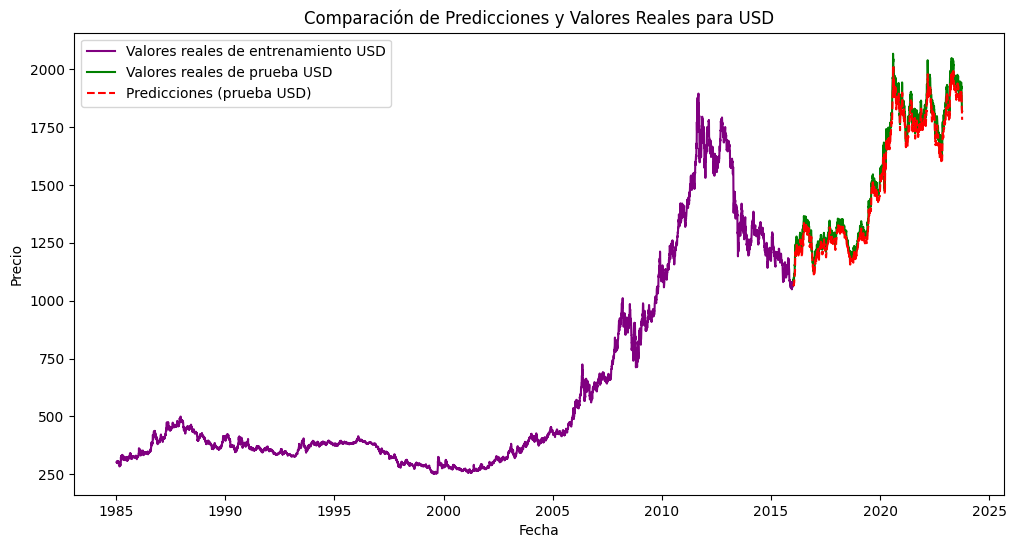

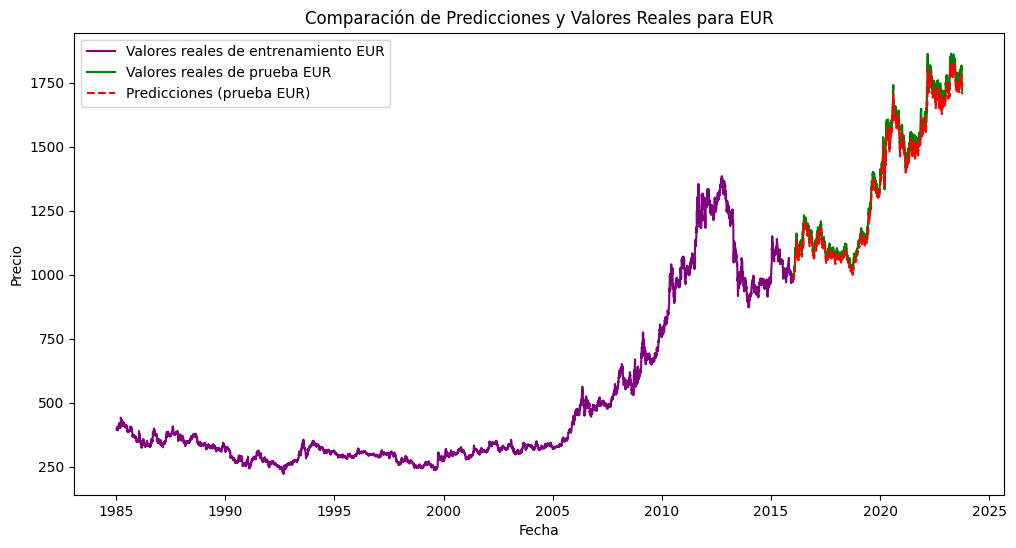

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Función para crear ventanas de datos multivariadas
def create_multivariate_windows(data, window_size, target_index):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, target_index])
    return np.array(X), np.array(y)

# Datos originales y tamaño de ventana
daily_gold_rate_ANN = daily_gold_rate_benchmark[['Date', 'USD', 'EUR']].dropna().copy()
train_size_ANN = int(len(daily_gold_rate_ANN) * 0.8)
train_data_ANN_og = daily_gold_rate_ANN[:train_size_ANN]
test_data_ANN_og = daily_gold_rate_ANN[train_size_ANN:]

train_data_values = train_data_ANN_og[['USD', 'EUR']].values
test_data_values = test_data_ANN_og[['USD', 'EUR']].values

# Crear ventanas para USD y EUR
window_size = 5
X_train_usd, y_train_usd = create_multivariate_windows(train_data_values, window_size, target_index=0)
X_test_usd, y_test_usd = create_multivariate_windows(test_data_values, window_size, target_index=0)
X_train_eur, y_train_eur = create_multivariate_windows(train_data_values, window_size, target_index=1)
X_test_eur, y_test_eur = create_multivariate_windows(test_data_values, window_size, target_index=1)

# Parámetros del modelo ANN (3 capas y 256 neuronas)
def build_large_ann_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(input_shape[0], input_shape[1])),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

# Entrenar el modelo para USD
model_usd = build_large_ann_model((X_train_usd.shape[1], X_train_usd.shape[2]))
history_usd = model_usd.fit(X_train_usd, y_train_usd, epochs=50, batch_size=64, verbose=0)

# Entrenar el modelo para EUR
model_eur = build_large_ann_model((X_train_eur.shape[1], X_train_eur.shape[2]))
history_eur = model_eur.fit(X_train_eur, y_train_eur, epochs=50, batch_size=64, verbose=0)

# Predicciones para entrenamiento y prueba en USD y EUR
y_pred_train_usd = model_usd.predict(X_train_usd).reshape(-1)
y_pred_test_usd = model_usd.predict(X_test_usd).reshape(-1)
y_pred_train_eur = model_eur.predict(X_train_eur).reshape(-1)
y_pred_test_eur = model_eur.predict(X_test_eur).reshape(-1)

# Calcular métricas de error para USD y EUR 
rmse_train_usd = np.sqrt(mean_squared_error( train_data_ANN_og['USD'].values[window_size:], y_pred_train_usd))
mae_train_usd = mean_absolute_error( train_data_ANN_og['USD'].values[window_size:], y_pred_train_usd)
mape_train_usd = np.mean(np.abs((train_data_ANN_og['USD'].values[window_size:] - y_pred_train_usd) / y_train_usd)) * 100

rmse_test_usd = np.sqrt(mean_squared_error(test_data_ANN_og['USD'].values[window_size:], y_pred_test_usd))
mae_test_usd = mean_absolute_error(test_data_ANN_og['USD'].values[window_size:], y_pred_test_usd)
mape_test_usd = np.mean(np.abs((test_data_ANN_og['USD'].values[window_size:] - y_pred_test_usd) / y_test_usd)) * 100

rmse_train_eur = np.sqrt(mean_squared_error(train_data_ANN_og['EUR'].values[window_size:], y_pred_train_eur))
mae_train_eur = mean_absolute_error(train_data_ANN_og['EUR'].values[window_size:], y_pred_train_eur)
mape_train_eur = np.mean(np.abs((train_data_ANN_og['EUR'].values[window_size:] - y_pred_train_eur) / y_train_eur)) * 100

rmse_test_eur = np.sqrt(mean_squared_error(test_data_ANN_og['EUR'].values[window_size:], y_pred_test_eur))
mae_test_eur = mean_absolute_error(test_data_ANN_og['EUR'].values[window_size:], y_pred_test_eur)
mape_test_eur = np.mean(np.abs((test_data_ANN_og['EUR'].values[window_size:] - y_pred_test_eur) / y_test_eur)) * 100

print(f"RMSE para USD (entrenamiento): {rmse_train_usd}")
print(f"MAE para USD (entrenamiento): {mae_train_usd}")
print(f"MAPE para USD (entrenamiento): {mape_train_usd}%")
print(f"RMSE para USD (prueba): {rmse_test_usd}")
print(f"MAE para USD (prueba): {mae_test_usd}")
print(f"MAPE para USD (prueba): {mape_test_usd}%")

print(f"RMSE para EUR (entrenamiento): {rmse_train_eur}")
print(f"MAE para EUR (entrenamiento): {mae_train_eur}")
print(f"MAPE para EUR (entrenamiento): {mape_train_eur}%")
print(f"RMSE para EUR (prueba): {rmse_test_eur}")
print(f"MAE para EUR (prueba): {mae_test_eur}")
print(f"MAPE para EUR (prueba): {mape_test_eur}%")

# Gráfico de resultados para USD
dates_train = train_data_ANN_og['Date'].values[window_size:]
dates_test = test_data_ANN_og['Date'].values[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_data_ANN_og['USD'].values[window_size:], label="Valores reales de entrenamiento USD", color="purple")
plt.plot(dates_test, test_data_ANN_og['USD'].values[window_size:], label="Valores reales de prueba USD", color="green")
plt.plot(dates_test, y_pred_test_usd, label="Predicciones (prueba USD)", linestyle="--", color="red")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Comparación de Predicciones y Valores Reales para USD")
plt.legend()
plt.show()

# Gráfico de resultados para EUR
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_data_ANN_og['EUR'].values[window_size:], label="Valores reales de entrenamiento EUR", color="purple")
plt.plot(dates_test, test_data_ANN_og['EUR'].values[window_size:], label="Valores reales de prueba EUR", color="green")
plt.plot(dates_test, y_pred_test_eur, label="Predicciones (prueba EUR)", linestyle="--", color="red")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Comparación de Predicciones y Valores Reales para EUR")
plt.legend()
plt.show()


### Interpretación de Resultados y Gráficos para Modelos ANN en USD y EUR

Los resultados obtenidos del modelo de redes neuronales artificiales (ANN) muestran un desempeño optimo en la predicción de los precios de **USD** y **EUR**, del cual se pueden destecar los siguientes puntos:

#### Interpretación de las Métricas de Error

1. **USD**:
   - En el conjunto de **entrenamiento**, el modelo ANN logró un **RMSE** de 11.69, un **MAE** de 7.6 y un **MAPE** de 1.24%. Esto indica un ajuste muy preciso sobre los datos de entrenamiento,indicando un modelo capaz de aprender patrones clave en la serie temporal.
   - En el conjunto de **prueba**, el **RMSE** fue de 21.66, el **MAE** de 17.60 y el **MAPE** de 1.7%. La ligera diferencia en las métricas de prueba en comparación con las métricas de entrenamiento es razonable y sugiere que el modelo generaliza bien, manteniendo una alta precisión en los datos no vistos.

2. **EUR**:
   - Para el **entrenamiento**, el modelo presentó un **RMSE** de 11.76, **MAE** de 7.95 y **MAPE** de 1.61%, lo que demuestra un rendimiento igualmente alto en la serie de EUR.
   - En el **conjunto de prueba**, el modelo mostró un **RMSE** de 21.91, **MAE** de 20.35 y **MAPE** de 1.63%. Estas métricas reafirman la robustez del modelo, logrando una predicción precisa incluso en datos no vistos.

3. **Comparación con el Modelo Holt-Winters**:
   - El modelo de Holt-Winters presentó métricas de error significativamente mayores en ambas divisas, con un **RMSE** de 131.86 para USD y 106.39 para EUR, y un **MAPE** de 6.69% y 6.50%, respectivamente. Comparado con estos valores, el modelo ANN reduce drásticamente el error en las predicciones, indicando una mejora sustancial en la precisión.

#### Análisis de los Gráficos de Predicción

- La línea de predicciones (en rojo) sigue de cerca las tendencias de los datos de prueba
- En ambas divisas, las predicciones reflejan los picos y valles de los datos reales, mostrando una capacidad del modelo para replicar tanto las tendencias de crecimiento como de descenso en el precio.

Esta representación visual muestra que el modelo no solo tiene un buen desempeño estadístico, sino que también logra una representación coherente de los patrones de cambio en el tiempo.

### Conclusiones Finales

El modelo ANN entrenado utilizando ventanas deslizantes ha demostrado ser altamente efectivo en la predicción de precios de **USD** y **EUR**. Los resultados destacan lo siguiente:

- **Precisión Mejorada**: El modelo ANN supera significativamente el desempeño del modelo Holt-Winters en todas las métricas de error.
- **Generalización Eficaz**: La pequeña diferencia entre las métricas de entrenamiento y prueba muestra que el modelo es capaz de generalizar bien, manteniendo su precisión en datos no vistos.
- **Utilidad Práctica**: Dado el bajo error porcentual (MAPE) tanto en USD como en EUR, este modelo ANN es una herramienta valiosa para la predicción de precios.
